# Statistical comparison for all models studied

## Previous


Esta celda detecta si el código se ejecuta en **Google Colab** o localmente, configura rutas base para guardar datasets y modelos, y crea los directorios necesarios si no existen.


In [40]:
from pathlib import Path
import os
import IPython

def detectar_entorno_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

def configurar_rutas(base_local=None, base_colab="/content/drive/MyDrive/ia_thermal_colab", verbose=True):
    IN_COLAB = detectar_entorno_colab()

    if IN_COLAB:
        from google.colab import drive
        drive.mount('/content/drive')
        base_path = Path(base_colab)
    else:
        # ⚠️ Si no se pasa base_local, usar el directorio del notebook
        if base_local is None:
            base_path = Path.cwd()
        else:
            base_path = Path(base_local).expanduser().resolve()

    datasets_path = base_path / "datasets"
    models_path = base_path / "models" / "ConvLSTM_6ch" / "stateful_O2O"
    figures_path = base_path / "figures" / "comparison_convlstm"
    datasets_path.mkdir(parents=True, exist_ok=True)
    models_path.mkdir(parents=True, exist_ok=True)
    figures_path.mkdir(parents=True, exist_ok=True)

    if verbose:
        print("✅ Entorno detectado:", "Colab" if IN_COLAB else "Local")
        print("📁 Ruta base:", base_path)
        print("📁 Ruta datasets:", datasets_path)
        print("📁 Ruta modelos:", models_path)
        print("📁 Ruta figures:", figures_path)

    return IN_COLAB, base_path, datasets_path, models_path, figures_path

# 🟢 Llamada principal
IN_COLAB, BASE_PATH, DATASETS_PATH, MODELS_PATH, FIGURES_PATH = configurar_rutas()


✅ Entorno detectado: Local
📁 Ruta base: c:\Users\ismag\OneDrive\Escritorio\ia_thermal\ismaelgallo
📁 Ruta datasets: c:\Users\ismag\OneDrive\Escritorio\ia_thermal\ismaelgallo\datasets
📁 Ruta modelos: c:\Users\ismag\OneDrive\Escritorio\ia_thermal\ismaelgallo\models\ConvLSTM_6ch\stateful_O2O
📁 Ruta figures: c:\Users\ismag\OneDrive\Escritorio\ia_thermal\ismaelgallo\figures\comparison_convlstm



Esta celda clona el repositorio del proyecto en Colab, instala las dependencias desde `requirements.txt` y reinicia el entorno para aplicar los cambios.

🔧 *Sugerencia*: podrías separar la clonación del repositorio y la instalación en funciones para mayor claridad y reutilización.


In [41]:
# 🔄 Parámetros del repositorio
GIT_REPO_URL = "https://github.com/ismaelgallolopez/ia_thermal.git"  # 👈 Cambia si usas otro repo
REPO_NAME = GIT_REPO_URL.split("/")[-1].replace(".git", "")
CLONE_PATH = BASE_PATH / REPO_NAME  # Usamos Path (de pathlib)

def clonar_repo_si_no_existe(repo_url: str, clone_path: Path):
    if not clone_path.exists():
        print(f"📥 Clonando repositorio en {clone_path}...")
        os.system(f"git clone {repo_url} {clone_path}")
    else:
        print(f"📂 Repositorio ya clonado en: {clone_path}")

def instalar_requirements(clone_path: Path):
    req_path = clone_path / "requirements.txt"
    if req_path.exists():
        print("📦 Instalando dependencias desde requirements.txt...")
        os.system(f"pip install -r {req_path}")
    else:
        print("⚠️ No se encontró requirements.txt en el repositorio.")

def reiniciar_entorno_colab():
    print("🔄 Reiniciando entorno para aplicar los cambios...")
    display(IPython.display.Javascript('''google.colab.restartRuntime()'''))

# 🧪 Ejecutar solo en Colab
if IN_COLAB:
    clonar_repo_si_no_existe(GIT_REPO_URL, CLONE_PATH)
    instalar_requirements(CLONE_PATH)
    reiniciar_entorno_colab()


Se importan todas las librerías necesarias, tanto estándar como personalizadas. También se configura el path para poder importar módulos específicos según el entorno.

In [42]:
# Librerías estándar
import os, sys, time, json, platform
from datetime import datetime
from typing import Sequence, Union, Optional


# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from IPython.display import display, Markdown

# NumPy y ciencia de datos
import numpy as np

# PyTorch y entrenamiento
import torch
from torch import nn, amp
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch._dynamo
from contextlib import nullcontext

# Añadir rutas del proyecto (de forma portable)
sys.path.append(str(BASE_PATH))
sys.path.append(str(BASE_PATH / "ia_thermal"))
sys.path.append(str(BASE_PATH / "ia_thermal" / "ismaelgallo"))
sys.path.append(str(BASE_PATH.parent))

# Módulos propios del proyecto
from architectures.convlstm import *
from Dataset_Class_convlstm import load_dataset_convlstm
from plot_functions import *
from Physics_Loss import *
from utils import *
from scripts.PCB_solver_tr import *

In [43]:
# =============== CONFIGURACIÓN DE MATPLOTLIB ===============
import matplotlib.pyplot as plt

plt.style.use('default')
plt.rcParams["figure.figsize"] = (6,4)
#plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.family"] = "lmroman10-regular"
plt.rcParams["font.size"] = 20
plt.rcParams["text.usetex"] = True
plt.rcParams["axes.titlesize"] = 20


Esta celda detecta si hay una GPU disponible y selecciona `cuda` si es posible; de lo contrario, usa `cpu`. Muestra por pantalla qué dispositivo se está utilizando.

In [44]:
device = seleccionar_dispositivo(use_cuda=True)

📟 Dispositivo seleccionado: cpu



Recopila información del sistema operativo, arquitectura, procesador, versión de Python, dispositivo de cómputo y, si hay GPU disponible, también su nombre, memoria y versión de CUDA.



In [45]:
system_specs = get_system_specs(device)
system_specs

{'os': 'Windows',
 'os_version': '10.0.26100',
 'machine': 'AMD64',
 'processor': 'AMD64 Family 23 Model 24 Stepping 1, AuthenticAMD',
 'python_version': '3.12.3',
 'device': 'cpu'}

## Auxiliar functions

Cajón desastre con las funciones requeridas para el análisis de este caso

In [46]:
np.random.seed(0)  # Para reproducibilidad

def generate_unique_cases(n_data):
    """
    Genera casos únicos evitando duplicados para asegurar diversidad en el análisis.
    
    Args:
        n_data: Número de casos únicos a generar
        
    Returns:
        Q_list: Array de potencias de heaters [W] - shape (n_data, 4)
        T_int_list: Array de temperaturas de interfaces [K] - shape (n_data, 4)  
        T_env_list: Array de temperaturas ambiente [K] - shape (n_data,)
    """
    seen = set()
    Q_list, T_int_list, T_env_list = [], [], []
    
    while len(Q_list) < n_data:
        # Generar condiciones aleatorias
        Q = tuple(np.random.uniform(0.5, 1.5, 4).round(6))        # Potencias [0.5-1.5W]
        T_int = tuple(np.random.uniform(270, 320, 4).round(2))    # Interfaces [270-320K]
        T_env = round(float(np.random.uniform(270, 320)), 2)      # Ambiente [270-320K]
        
        # Crear clave única para evitar duplicados
        key = Q + T_int + (T_env,)
        
        if key not in seen:
            seen.add(key)
            Q_list.append(Q)
            T_int_list.append(T_int)
            T_env_list.append(T_env)
    
    return np.array(Q_list), np.array(T_int_list), np.array(T_env_list)

In [47]:
def load_model_by_hyperparameters(models_path, n_train=None, time_sim=None, dt=None, 
                                 batch_sizes=None, hidden_dims=None, kernel_size=None,
                                 device='cpu', verbose=True, exclude_physics=True, 
                                 physics_keywords=None, exclude_keywords=None,
                                 load_configs=True):
    """
    Función para cargar modelos automáticamente basándose en hiperparámetros específicos.
    
    Args:
        models_path: Path donde están guardados los modelos
        n_train: número de datos de entrenamiento (int/list: ej: 1000 o [250, 500, 1000])
        time_sim: tiempo de simulación (int/list: ej: 50 o [50, 100])
        dt: delta tiempo (int/list: ej: 1 o [1, 2])
        batch_sizes: lista de batch sizes a buscar (list: ej: [16, 32, 64])
        hidden_dims: dimensiones ocultas (list/list of lists: ej: [64, 64] o [[32,32], [64,64]])
        kernel_size: tamaño del kernel (tuple/list: ej: (3,3) o [(3,3), (5,5)])
        device: dispositivo donde cargar el modelo
        verbose: mostrar información de carga
        exclude_physics: si True, excluye modelos con implementación de física
        physics_keywords: lista de palabras clave que indican modelos con física
        exclude_keywords: lista adicional de palabras clave a excluir
        load_configs: si True, carga también los archivos JSON de configuración
        
    Returns:
        dict: diccionario con los modelos cargados {nombre_modelo: modelo}
        dict: diccionario con las configuraciones JSON {nombre_modelo: config} (si load_configs=True)
    """
    
    # Palabras clave por defecto para modelos con física
    if physics_keywords is None:
        physics_keywords = ['phy', 'bnd', 'mse']
    
    # Palabras clave adicionales a excluir
    if exclude_keywords is None:
        exclude_keywords = []
    
    # Combinar todas las palabras clave a excluir
    all_exclude_keywords = []
    if exclude_physics:
        all_exclude_keywords.extend(physics_keywords)
    all_exclude_keywords.extend(exclude_keywords)
    
    # 🔧 NORMALIZAR TODOS LOS HIPERPARÁMETROS A LISTAS
    def normalize_to_list(param, param_name):
        """Convierte parámetro a lista, maneja None como 'todos los valores'"""
        if param is None:
            return [None]  # Indica que debe buscar todos los valores
        elif isinstance(param, (list, tuple)):
            return list(param)
        else:
            return [param]
    
    n_train_list = normalize_to_list(n_train, 'n_train')
    time_sim_list = normalize_to_list(time_sim, 'time_sim')
    dt_list = normalize_to_list(dt, 'dt')
    batch_sizes_list = normalize_to_list(batch_sizes, 'batch_sizes')
    
    # Para hidden_dims, manejar casos especiales
    if hidden_dims is None:
        hidden_dims_list = [None]
    elif isinstance(hidden_dims[0], (list, tuple)):
        # Es una lista de listas: [[32,32], [64,64]]
        hidden_dims_list = hidden_dims
    else:
        # Es una lista simple: [64, 64]
        hidden_dims_list = [hidden_dims]
    
    # Para kernel_size, manejar casos especiales
    if kernel_size is None:
        kernel_size_list = [None]
    elif isinstance(kernel_size, tuple):
        # Es una tupla simple: (3,3)
        kernel_size_list = [kernel_size]
    elif isinstance(kernel_size[0], tuple):
        # Es una lista de tuplas: [(3,3), (5,5)]
        kernel_size_list = kernel_size
    else:
        # Es una lista de listas: [[3,3], [5,5]]
        kernel_size_list = [tuple(ks) for ks in kernel_size]
    
    # 🔧 GENERAR TODAS LAS COMBINACIONES DE PATRONES
    search_patterns = []
    
    for nt in n_train_list:
        for ts in time_sim_list:
            for dt_val in dt_list:
                for hd in hidden_dims_list:
                    for ks in kernel_size_list:
                        for bs in batch_sizes_list:
                            
                            # Construir patrón base
                            pattern = "PCB_ConvLSTM_6ch"
                            
                            # Agregar n_train (solo si no es None)
                            if nt is not None:
                                pattern += f"_nt{nt}"
                            
                            # Agregar time_sim (solo si no es None)
                            if ts is not None:
                                pattern += f"_{ts}s"
                            
                            # Agregar dt (solo si no es None)
                            if dt_val is not None:
                                pattern += f"_dt{dt_val}"
                            
                            # Agregar batch_size (solo si no es None)
                            if bs is not None:
                                pattern += f"_bs{bs}"
                            
                            # Agregar hidden_dims (solo si no es None)
                            if hd is not None:
                                layer_string = "-".join(str(d) for d in hd)
                                pattern += f"_h{layer_string}"
                            
                            # Agregar kernel_size (solo si no es None)
                            if ks is not None:
                                kernel_string = f"{ks[0]}x{ks[1]}"
                                pattern += f"_k{kernel_string}"
                            
                            search_patterns.append(pattern)
    
    # Eliminar patrones duplicados
    search_patterns = list(set(search_patterns))
    
    if verbose:
        print(f"🔍 Buscando modelos con patrones:")
        for pattern in search_patterns[:10]:  # Mostrar solo los primeros 10
            print(f"   📝 {pattern}")
        if len(search_patterns) > 10:
            print(f"   ... y {len(search_patterns) - 10} patrones más")
        
        if exclude_physics:
            print(f"🚫 Excluyendo modelos con palabras clave de física: {physics_keywords}")
        if exclude_keywords:
            print(f"🚫 Excluyendo modelos con palabras clave adicionales: {exclude_keywords}")
        if load_configs:
            print(f"📋 Cargando también archivos JSON de configuración")
    
    # 🔧 BÚSQUEDA INTELIGENTE DE ARCHIVOS
    loaded_models = {}
    loaded_configs = {}
    excluded_files = []
    models_path = Path(models_path)
    
    # Obtener todos los archivos .pth disponibles
    all_pth_files = list(models_path.glob("*.pth"))
    
    for pattern in search_patterns:
        # Si el patrón contiene None (wildcards), usar búsqueda especial
        if pattern == "PCB_ConvLSTM_6ch":
            # Patrón completamente genérico, buscar todos los archivos
            matching_files = all_pth_files
        else:
            # Búsqueda específica por patrón
            matching_files = []
            
            for pth_file in all_pth_files:
                filename = pth_file.name
                
                # Si hay Nones en los parámetros, usar matching flexible
                if any(param is None for param in [nt, ts, dt_val, bs, hd, ks] 
                       for nt in n_train_list for ts in time_sim_list 
                       for dt_val in dt_list for bs in batch_sizes_list 
                       for hd in hidden_dims_list for ks in kernel_size_list):
                    
                    # Matching flexible: verificar que las partes especificadas estén presentes
                    pattern_parts = pattern.replace("PCB_ConvLSTM_6ch_", "").split("_")
                    pattern_parts = [part for part in pattern_parts if part]  # Remover vacíos
                    
                    if all(part in filename for part in pattern_parts):
                        matching_files.append(pth_file)
                else:
                    # Matching exacto
                    if pattern in filename:
                        matching_files.append(pth_file)
        
        # Procesar archivos encontrados
        for model_file in matching_files:
            filename = model_file.stem.lower()  # Convertir a minúsculas para comparación
            
            # Verificar si ya fue procesado
            model_name = model_file.stem.replace("PCB_ConvLSTM_6ch_", "")
            if model_name in loaded_models:
                continue
            
            # Verificar si el archivo contiene palabras clave a excluir
            should_exclude = False
            excluded_reason = ""
            
            for keyword in all_exclude_keywords:
                if keyword.lower() in filename:
                    should_exclude = True
                    excluded_reason = f"contiene '{keyword}'"
                    break
            
            if should_exclude:
                excluded_files.append((model_file.name, excluded_reason))
                if verbose:
                    print(f"🚫 Excluido: {model_file.name} ({excluded_reason})")
                continue
            
            try:
                # Extraer hiperparámetros del nombre del archivo para crear el modelo
                filename_original = model_file.stem
                
                # Extraer hidden_dims del nombre
                if "_h" in filename_original:
                    h_part = filename_original.split("_h")[1].split("_")[0]
                    model_hidden_dims = [int(x) for x in h_part.split("-")]
                else:
                    model_hidden_dims = hidden_dims_def
                
                # Extraer kernel_size del nombre  
                if "_k" in filename_original:
                    k_part = filename_original.split("_k")[1].split("_")[0]
                    k_size = tuple(map(int, k_part.split("x")))
                    model_kernel_size = [(k_size)] * len(model_hidden_dims)
                else:
                    model_kernel_size = kernel_size_def
                
                # Crear la arquitectura del modelo
                model = PCB_ConvLSTM(
                    input_channels=6,
                    hidden_dims=model_hidden_dims,
                    kernel_size=model_kernel_size,
                    height=13,
                    width=13
                )
                
                # Cargar los pesos
                checkpoint = torch.load(model_file, map_location=device)
                
                # Manejar diferentes formatos de checkpoint
                if isinstance(checkpoint, dict):
                    if 'model_state_dict' in checkpoint:
                        model.load_state_dict(checkpoint['model_state_dict'])
                    elif 'state_dict' in checkpoint:
                        model.load_state_dict(checkpoint['state_dict'])
                    else:
                        # Asumir que el checkpoint completo es el state_dict
                        model.load_state_dict(checkpoint)
                else:
                    model.load_state_dict(checkpoint)
                
                model.to(device)
                model.eval()
                
                # Crear nombre descriptivo para el modelo
                loaded_models[model_name] = model
                
                # Cargar archivo JSON de configuración si existe
                config_loaded = False
                if load_configs:
                    # Buscar archivo JSON con el mismo nombre base
                    json_file = model_file.with_suffix('.json')
                    if json_file.exists():
                        try:
                            with open(json_file, 'r', encoding='utf-8') as f:
                                config = json.load(f)
                            loaded_configs[model_name] = config
                            config_loaded = True
                            if verbose:
                                print(f"   📋 Config cargado: {json_file.name}")
                        except Exception as e:
                            if verbose:
                                print(f"   ⚠️ Error cargando config {json_file.name}: {str(e)}")
                    else:
                        if verbose:
                            print(f"   📋 No se encontró config para: {model_file.name}")
                
                if verbose:
                    print(f"✅ Cargado: {model_name}")
                    print(f"   📁 Archivo: {model_file.name}")
                    print(f"   🧠 Hidden dims: {model_hidden_dims}")
                    print(f"   🔲 Kernel size: {model_kernel_size[0]}")
                    if load_configs:
                        print(f"   📋 Config: {'✅' if config_loaded else '❌'}")
                
            except Exception as e:
                if verbose:
                    print(f"❌ Error cargando {model_file.name}: {str(e)}")
                continue
    
    if not loaded_models:
        print("⚠️ No se encontraron modelos que coincidan con los criterios especificados.")
        print(f"📂 Buscando en: {models_path}")
        print(f"🔍 Patrones buscados: {search_patterns[:5]}...")  # Mostrar solo algunos
        
        # Mostrar archivos disponibles
        available_files = list(models_path.glob("*.pth"))
        if available_files:
            print(f"\n📋 Archivos disponibles en {models_path}:")
            for f in available_files[:10]:  # Mostrar solo los primeros 10
                print(f"   📄 {f.name}")
            if len(available_files) > 10:
                print(f"   ... y {len(available_files) - 10} más")
    
    if verbose and excluded_files:
        print(f"\n📋 Resumen de archivos excluidos:")
        for filename, reason in excluded_files:
            print(f"   🚫 {filename} - {reason}")
    
    if load_configs:
        if verbose:
            print(f"\n📊 Resumen de carga:")
            print(f"   🤖 Modelos cargados: {len(loaded_models)}")
            print(f"   📋 Configs cargados: {len(loaded_configs)}")
        return loaded_models, loaded_configs
    else:
        return loaded_models


# Función actualizada para cargar solo modelos sin física (con configs)
def load_batch_size_comparison_models(models_path, device='cpu', load_configs=True):
    """Carga modelos específicos para comparación de batch sizes (sin física)."""
    return load_model_by_hyperparameters(
        models_path=models_path,
        n_train=1000,                           # Fijo
        time_sim=50,                           # Fijo
        dt=1,                                  # Fijo
        batch_sizes=[8, 16, 32, 64, 128, 256], # Variable
        hidden_dims=[64, 64],                  # Fijo
        kernel_size=(3, 3),                    # Fijo
        device=device,
        exclude_physics=True,
        load_configs=load_configs,
        verbose=True
    )

def load_training_cases_comparison_models(models_path, device='cpu', load_configs=True):
    """Carga modelos específicos para comparación de training cases."""
    return load_model_by_hyperparameters(
        models_path=models_path,
        n_train=[100, 250, 500, 1000, 2000, 4000],  # Variable
        time_sim=50,                                 # Fijo
        dt=1,                                        # Fijo
        batch_sizes=16,                              # Fijo
        hidden_dims=[64, 64],                        # Fijo
        kernel_size=(3, 3),                          # Fijo
        device=device,
        exclude_physics=True,
        load_configs=load_configs,
        verbose=True
    )

def load_architecture_comparison_models(models_path, device='cpu', load_configs=True):
    """Carga modelos específicos para comparación de arquitecturas."""
    return load_model_by_hyperparameters(
        models_path=models_path,
        n_train=1000,                               # Fijo
        time_sim=50,                                # Fijo
        dt=1,                                       # Fijo
        batch_sizes=16,                             # Fijo
        hidden_dims=[[32, 32], [64, 64], [128, 128]], # Variable
        kernel_size=[(3, 3), (5, 5)],              # Variable
        device=device,
        exclude_physics=True,
        load_configs=load_configs,
        verbose=True
    )

def load_time_simulation_comparison_models(models_path, device='cpu', load_configs=True):
    """Carga modelos específicos para comparación de tiempos de simulación."""
    return load_model_by_hyperparameters(
        models_path=models_path,
        n_train=1000,                    # Fijo
        time_sim=[50, 100, 200, 500],    # Variable
        dt=1,                            # Fijo
        batch_sizes=16,                  # Fijo
        hidden_dims=[64, 64],            # Fijo
        kernel_size=(3, 3),              # Fijo
        device=device,
        exclude_physics=True,
        load_configs=load_configs,
        verbose=True
    )

def load_all_models_wildcard(models_path, device='cpu', load_configs=True):
    """Carga TODOS los modelos disponibles (usando wildcards)."""
    return load_model_by_hyperparameters(
        models_path=models_path,
        n_train=None,        # Todos los valores
        time_sim=None,       # Todos los valores
        dt=None,             # Todos los valores
        batch_sizes=None,    # Todos los valores
        hidden_dims=None,    # Todos los valores
        kernel_size=None,    # Todos los valores
        device=device,
        exclude_physics=True,
        load_configs=load_configs,
        verbose=True
    )

def load_physics_models_comparison(models_path, device='cpu', load_configs=True):
    """Carga específicamente modelos con implementación de física."""
    return load_model_by_hyperparameters(
        models_path=models_path,
        n_train=1000,
        time_sim=50,
        dt=1,
        batch_sizes=[16, 32, 64],
        hidden_dims=[64, 64],
        kernel_size=(3, 3),
        device=device,
        exclude_physics=False,  # NO excluir modelos con física
        exclude_keywords=[],    # Lista vacía
        load_configs=load_configs,
        verbose=True
    )


# Función para cargar solo modelos con física (con configs)
def load_physics_models(models_path, device='cpu', load_configs=True):
    """
    Carga específicamente modelos con implementación de física.
    """
    return load_model_by_hyperparameters(
        models_path=models_path,
        n_train=1000,
        time_sim=50,
        dt=1,
        batch_sizes=[16, 32, 64],
        hidden_dims=[64, 64],
        kernel_size=(3, 3),
        device=device,
        exclude_physics=False,  # No excluir modelos con física
        exclude_keywords=[],    # Lista vacía para no excluir nada adicional
        load_configs=load_configs,
        verbose=True
    )


# Función para cargar modelos con palabras clave específicas a excluir (con configs)
def load_custom_filtered_models(models_path, exclude_keywords_custom=None, device='cpu', load_configs=True):
    """
    Carga modelos con filtros personalizados.
    """
    if exclude_keywords_custom is None:
        exclude_keywords_custom = []
        
    return load_model_by_hyperparameters(
        models_path=models_path,
        n_train=1000,
        time_sim=50,
        dt=1,
        batch_sizes=[16, 32, 64],
        hidden_dims=[64, 64],
        kernel_size=(3, 3),
        device=device,
        exclude_physics=True,
        exclude_keywords=exclude_keywords_custom,  # Palabras clave adicionales a excluir
        load_configs=load_configs,
        verbose=True
    )

In [48]:
def calculate_convlstm_error_by_timestep(model, dataset, T_transient_all, Q_cases, 
                                        T_interfaces_cases, T_env_cases, device=None, 
                                        sequence_length=None, display=True):
    """
    Calculates the ConvLSTM error per time step comparing ConvLSTM predictions 
    with solver solutions using the autoregressive process.
    
    Parameters:
        model: trained ConvLSTM model
        dataset: PCBDataset_convlstm object
        T_transient_all: array (n_cases, time_steps, 169) with solver solutions
        Q_cases: array (n_cases, 4) with heater powers
        T_interfaces_cases: array (n_cases, 4) with interface temperatures  
        T_env_cases: array (n_cases,) with environment temperatures
        device: computation device
        sequence_length: sequence length for model input (if None, uses T_transient_all.shape[1])
        display: whether to show progress information
        
    Returns:
        dict with error statistics per timestep
    """
    
    if device is None:
        device = next(model.parameters()).device
    
    model.eval()
    
    n_cases, time_steps, spatial_nodes = T_transient_all.shape
    H, W = 13, 13
    
    # Verify spatial nodes
    if spatial_nodes != H * W:
        raise ValueError(f"Expected {H*W} spatial nodes, got {spatial_nodes}")
    
    if sequence_length is None:
        sequence_length = time_steps
    elif sequence_length > time_steps:
        raise ValueError(f"sequence_length ({sequence_length}) cannot be larger than available time steps ({time_steps})")
    
    if display:
        print(f"🔄 Calculating ConvLSTM error by timestep (autoregressive)")
        print(f"   📊 Cases: {n_cases}")
        print(f"   ⏱️ Time steps: {time_steps}")
        print(f"   🔗 Sequence length: {sequence_length}")
        print(f"   🌐 Spatial nodes: {spatial_nodes} ({H}x{W})")
    
    # Storage for errors per timestep
    mae_per_timestep = np.zeros(sequence_length)
    mse_per_timestep = np.zeros(sequence_length)
    rmse_per_timestep = np.zeros(sequence_length)
    std_per_timestep = np.zeros(sequence_length)
    max_per_timestep = np.zeros(sequence_length)
    min_per_timestep = np.zeros(sequence_length)
    
    # Storage for all predictions and errors
    all_predictions = np.zeros((n_cases, sequence_length, H, W))
    all_errors = np.zeros((n_cases, sequence_length, H, W))
    
    # Process each case
    for i in tqdm(range(n_cases), desc="Processing cases", disable=not display):
        # Get conditions for this case
        Q = Q_cases[i]
        T_int = T_interfaces_cases[i] 
        T_env = T_env_cases[i]
        
        # Get solver solution (ground truth) and reshape to (time_steps, H, W)
        T_true_flat = T_transient_all[i, :sequence_length]  # (time_steps, 169)
        T_true = T_true_flat.reshape(sequence_length, H, W)  # (time_steps, H, W)
        
        # =============== CONVLSTM AUTOREGRESSIVE PREDICTION ===============
        # Use initial temperature from solver
        T_seq_initial = T_true[0]  # Use first timestep from solver as initial condition
        
        # 1) Primer input (1,1,6,13,13)
        input0 = dataset.create_input_from_values(
            Q, T_int, T_env,
            T_seq=np.expand_dims(T_seq_initial, 0),
            sequence_length=sequence_length,
            autorregress=True
        ).to(device)

        # 2) Prepara contornos y t_prev
        # bc_static: (1, seq_len, 5, 13,13)
        bc_static = input0[:, :1, :5, :, :].repeat(1, sequence_length, 1, 1, 1)
        # t_prev: (1,1,1,13,13)
        t_prev = input0[:, :1, 5:6, :, :]

        # 3) Roll-out autoregresivo
        preds_norm = []
        hidden = None
        with torch.no_grad():
            for t in range(sequence_length):
                # concatenar por canal (dim=2)
                x_t = torch.cat([bc_static[:, t:t+1], t_prev], dim=2)  # → (1,1,6,13,13)
                pred_t, hidden = model.forward_step(x_t, hidden)       # → (1,1,1,13,13)
                t_prev = pred_t                                        # mantener shape
                preds_norm.append(t_prev)

        preds_norm = torch.cat(preds_norm, dim=1)  # (1, T, 1, 13,13)

        # 4) Desnormalizar
        mean = dataset.T_outputs_mean.to(device)
        std_dev = dataset.T_outputs_std.to(device)
        preds_denorm = preds_norm * std_dev + mean      # (1, T, 1, H, W)
        T_pred = preds_denorm.squeeze(0).squeeze(1).cpu().numpy()  # (T, 13, 13)
        
        # Store predictions
        all_predictions[i] = T_pred
        
        # Calculate errors for this case
        case_errors = np.abs(T_true - T_pred)  # Absolute error (time_steps, H, W)
        all_errors[i] = case_errors
    
    # Calculate statistics across all cases for each timestep
    for t in range(sequence_length):
        errors_t = all_errors[:, t, :, :]  # (n_cases, H, W)
        
        # Flatten spatial dimensions for statistics
        errors_flat = errors_t.flatten()  # (n_cases * H * W,)
        
        mae_per_timestep[t] = np.mean(errors_flat)
        mse_per_timestep[t] = np.mean(errors_flat**2)
        rmse_per_timestep[t] = np.sqrt(mse_per_timestep[t])
        std_per_timestep[t] = np.std(errors_flat)
        max_per_timestep[t] = np.max(errors_flat)
        min_per_timestep[t] = np.min(errors_flat)
    
    # Calculate overall statistics
    overall_mae = np.mean(mae_per_timestep)
    overall_rmse = np.mean(rmse_per_timestep)
    overall_std = np.mean(std_per_timestep)
    
    # Create time array
    time_array = np.arange(sequence_length)
    
    if display:
        print(f"\n📊 CONVLSTM ERROR ANALYSIS RESULTS:")
        print(f"   Overall MAE: {overall_mae:.3f} K")
        print(f"   Overall RMSE: {overall_rmse:.3f} K") 
        print(f"   Overall STD: {overall_std:.3f} K")
        print(f"   Initial timestep MAE: {mae_per_timestep[0]:.3f} K")
        print(f"   Final timestep MAE: {mae_per_timestep[-1]:.3f} K")
        print(f"   Maximum timestep error: {np.max(mae_per_timestep):.3f} K at t={np.argmax(mae_per_timestep)}")
    
    # Prepare results dictionary (same format as other models)
    results = {
        # Error statistics per timestep
        'time_array': time_array,
        'mae_per_timestep': mae_per_timestep,
        'mse_per_timestep': mse_per_timestep,
        'rmse_per_timestep': rmse_per_timestep,
        'std_per_timestep': std_per_timestep,
        'max_per_timestep': max_per_timestep,
        'min_per_timestep': min_per_timestep,
        
        # Overall statistics
        'overall_mae': overall_mae,
        'overall_rmse': overall_rmse,
        'overall_std': overall_std,
        
        # Complete arrays (reshaped to spatial format for analysis)
        'all_predictions': all_predictions,    # (n_cases, time_steps, H, W)
        'all_errors': all_errors,              # (n_cases, time_steps, H, W)
        'T_true_reshaped': T_transient_all[:, :sequence_length].reshape(n_cases, sequence_length, H, W),  # (n_cases, time_steps, H, W)
        
        # Original flat format
        'T_true_flat': T_transient_all[:, :sequence_length],  # (n_cases, time_steps, 169)
        
        # Metadata
        'n_cases': n_cases,
        'sequence_length': sequence_length,
        'spatial_nodes': spatial_nodes,
        'spatial_shape': (H, W)
    }
    
    return results



def plot_error_with_std_bands(results, save_as_pdf=False, filename='error_with_std_bands'):
    """
    Plots average error over time with standard deviation bands.
    
    Parameters:
        results: results dictionary from calculate_network_error_by_timestep
        save_as_pdf: if True, saves the figure as PDF in the 'figures' folder
        filename: base filename (without extension)
    """
    
    time_array = results['time_array']
    mae_per_timestep = results['mae_per_timestep']
    std_per_timestep = results['std_per_timestep']
    
    # Calculate upper and lower bounds for std bands
    upper_bound = mae_per_timestep + std_per_timestep
    lower_bound = mae_per_timestep - std_per_timestep
    
    # Ensure lower bound is not negative
    lower_bound = np.maximum(lower_bound, 0)
    
    # =============== FIGURE CONFIGURATION WITH WHITE BACKGROUND ===============
    fig, ax = plt.subplots(figsize=(12, 6))
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    
    # Plot the standard deviation bands
    ax.fill_between(time_array, lower_bound, upper_bound, 
                    alpha=0.3, color='#1f77b4', label='Mean ± Std Dev')
    
    # Plot the mean error line
    ax.plot(time_array, mae_per_timestep, label='Mean Absolute Error', 
            linewidth=2, color='#1f77b4')
    
    # Configure axes
    ax.set_xlabel('Time [s]', color='black')  # Cambiado de 'Time Step' a 'Time [s]'
    ax.set_ylabel('Error [K]', color='black')
    
    # Title only for visualization (will be removed when saving PDF)
    title_handle = ax.set_title('Network Error Evolution with Standard Deviation', color='black')
    
    # Set axis limits
    ax.set_xlim(time_array[0], time_array[-1])
    ax.set_ylim(0, np.max(upper_bound) * 1.05)
    
    # Configure grid and legend
    ax.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
    ax.legend()
    ax.tick_params(colors='black')
    
    plt.tight_layout()
    
    if save_as_pdf:
        # Remove title before saving
        title_handle.set_visible(False)
        os.makedirs('figures', exist_ok=True)
        plt.savefig(f'figures/comparison_convlstm/{filename}.pdf', format='pdf', facecolor='white')
        # Restore title for visualization
        title_handle.set_visible(True)
    
    plt.show()


def plot_error_range_per_timestep(results, save_as_pdf=False, filename='error_range_per_timestep'):
    """
    Plots error range (min-max) with mean error line for each timestep.
    This is the separated "Error Range per Timestep" plot.
    
    Parameters:
        results: results dictionary from calculate_network_error_by_timestep
        save_as_pdf: if True, saves the figure as PDF in the 'figures' folder
        filename: base filename (without extension)
    """
    
    time_array = results['time_array']
    mae_per_timestep = results['mae_per_timestep']
    min_per_timestep = results['min_per_timestep']
    max_per_timestep = results['max_per_timestep']
    
    # =============== FIGURE CONFIGURATION WITH WHITE BACKGROUND ===============
    fig, ax = plt.subplots(figsize=(12, 6))
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    
    # Plot the min-max range as filled area
    ax.fill_between(time_array, min_per_timestep, max_per_timestep, 
                    alpha=0.3, color='#d62728', label='Min-Max Range')
    
    # Plot the mean error line
    ax.plot(time_array, mae_per_timestep, label='Mean Absolute Error', 
            linewidth=2, color='#1f77b4')
    
    # Configure axes
    ax.set_xlabel('Time [s]', color='black')  # Cambiado de 'Time Step' a 'Time [s]'
    ax.set_ylabel('Error [K]', color='black')
    
    # Title only for visualization (will be removed when saving PDF)
    title_handle = ax.set_title('Error Range per Timestep', color='black')
    
    # Set axis limits
    ax.set_xlim(time_array[0], time_array[-1])
    ax.set_ylim(0, np.max(max_per_timestep) * 1.05)
    
    # Configure grid and legend
    ax.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
    ax.legend()
    ax.tick_params(colors='black')
    
    plt.tight_layout()
    
    if save_as_pdf:
        # Remove title before saving
        title_handle.set_visible(False)
        os.makedirs('figures', exist_ok=True)
        plt.savefig(f'figures/comparison_convlstm/{filename}.pdf', format='pdf', facecolor='white')
        # Restore title for visualization
        title_handle.set_visible(True)
    
    plt.show()


def compare_models_error_by_timestep(models_dict, dataset, T_transient_all, Q_cases, 
                                   T_interfaces_cases, T_env_cases, device=None,
                                   sequence_length=None, save_as_pdf=False, 
                                   filename='models_error_comparison_timestep'):
    """
    Compares multiple models' error evolution over timesteps.
    
    Parameters:
        models_dict: dict with model_name: model pairs
        dataset: dataset object for normalization/denormalization
        T_transient_all: array (n_cases, time_steps, 169) with solver solutions
        Q_cases, T_interfaces_cases, T_env_cases: condition arrays
        device: computation device
        sequence_length: sequence length for model input
        save_as_pdf: if True, saves the figure as PDF
        filename: base filename (without extension)
        
    Returns:
        dict with results for each model
    """
    
    comparison_results = {}
    
    n_cases, time_steps, spatial_nodes = T_transient_all.shape
    
    print(f"🔄 Comparing {len(models_dict)} models error by timestep")
    print(f"   📊 Data shape: {T_transient_all.shape}")
    print(f"   🌐 Spatial nodes: {spatial_nodes}")
    
    # Calculate errors for each model
    for model_name, model in models_dict.items():
        print(f"\n🤖 Analyzing {model_name}...")
        
        results = calculate_network_error_by_timestep(
            model=model,
            dataset=dataset,
            T_transient_all=T_transient_all,
            Q_cases=Q_cases,
            T_interfaces_cases=T_interfaces_cases,
            T_env_cases=T_env_cases,
            device=device,
            sequence_length=sequence_length,
            display=False
        )
        
        comparison_results[model_name] = results
    
    # Plot comparison
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    fig.patch.set_facecolor('white')
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
    
    # Get time array (should be same for all models)
    time_array = list(comparison_results.values())[0]['time_array']
    
    for i, (model_name, results) in enumerate(comparison_results.items()):
        color = colors[i % len(colors)]
        
        # MAE comparison
        ax1.set_facecolor('white')
        ax1.plot(time_array, results['mae_per_timestep'], label=model_name, 
                linewidth=2, color=color)
        
        # RMSE comparison  
        ax2.set_facecolor('white')
        ax2.plot(time_array, results['rmse_per_timestep'], label=model_name,
                linewidth=2, color=color)
        
        # STD comparison
        ax3.set_facecolor('white') 
        ax3.plot(time_array, results['std_per_timestep'], label=model_name,
                linewidth=2, color=color)
        
        # Max error comparison
        ax4.set_facecolor('white')
        ax4.plot(time_array, results['max_per_timestep'], label=model_name,
                linewidth=2, color=color)
    
    # Configure subplots
    titles = ['Mean Absolute Error', 'Root Mean Square Error', 
             'Standard Deviation', 'Maximum Error']
    ylabels = ['MAE [K]', 'RMSE [K]', 'STD [K]', 'Max Error [K]']
    
    for ax, title, ylabel in zip([ax1, ax2, ax3, ax4], titles, ylabels):
        ax.set_ylabel(ylabel, color='black')
        ax.set_title(title, color='black')
        ax.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
        ax.legend()
        ax.tick_params(colors='black')
        ax.set_xlim(time_array[0], time_array[-1])
    
    # Set x-labels for bottom plots
    ax3.set_xlabel('Time Step', color='black')
    ax4.set_xlabel('Time Step', color='black')
    
    # Main title only for visualization
    title_handle = fig.suptitle('Models Error Comparison by Timestep', 
                               fontsize=16, color='black')
    
    plt.tight_layout()
    
    if save_as_pdf:
        # Remove title before saving
        title_handle.set_visible(False)
        os.makedirs('figures', exist_ok=True)
        plt.savefig(f'figures/{filename}.pdf', format='pdf', facecolor='white')
        # Restore title for visualization
        title_handle.set_visible(True)
    
    plt.show()
    
    # Print summary
    print(f"\n🏆 MODELS COMPARISON SUMMARY:")
    print("="*70)
    print(f"{'Model':<20} {'Overall MAE':<12} {'Overall RMSE':<12} {'Final MAE':<12}")
    print("-"*70)
    
    for model_name, results in comparison_results.items():
        print(f"{model_name:<20} {results['overall_mae']:<12.3f} "
              f"{results['overall_rmse']:<12.3f} {results['mae_per_timestep'][-1]:<12.3f}")
    
    return comparison_results



def plot_models_comparison_with_std_bands(comparison_results, save_as_pdf=False, 
                                        filename='models_comparison_with_std_bands'):
    """
    Plots comparison of multiple models with error and standard deviation bands.
    
    Parameters:
        comparison_results: dict with model_name: results pairs
        save_as_pdf: if True, saves the figure as PDF in the 'figures' folder
        filename: base filename (without extension)
    """
    
    # =============== FIGURE CONFIGURATION WITH WHITE BACKGROUND ===============
    fig, ax = plt.subplots(figsize=(14, 7))
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    
    # Colors for different models
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
    
    # Get time array (should be the same for all models)
    time_array = list(comparison_results.values())[0]['time_array']
    
    for i, (model_name, results) in enumerate(comparison_results.items()):
        color = colors[i % len(colors)]
        
        mae_per_timestep = results['mae_per_timestep']
        std_per_timestep = results['std_per_timestep']
        
        # Calculate bounds
        upper_bound = mae_per_timestep + std_per_timestep
        lower_bound = np.maximum(mae_per_timestep - std_per_timestep, 0)
        
        # Plot std deviation bands
        ax.fill_between(time_array, lower_bound, upper_bound, 
                        alpha=0.2, color=color, 
                        label=f'{model_name} ± Std Dev')
        
        # Plot mean error line
        ax.plot(time_array, mae_per_timestep, 
                linewidth=2, color=color, label=f'{model_name} Mean Error')
    
    # Configure axes
    ax.set_xlabel('Time [s]', color='black')  # Cambiado de 'Time Step' a 'Time [s]'
    ax.set_ylabel('Error [K]', color='black')
    
    # Title only for visualization
    title_handle = ax.set_title('Models Comparison: Error Evolution with Standard Deviation', 
                               color='black')
    
    # Set axis limits
    ax.set_xlim(time_array[0], time_array[-1])
    
    # Calculate global upper bound for y-axis
    max_upper = 0
    for results in comparison_results.values():
        upper_bound = results['mae_per_timestep'] + results['std_per_timestep']
        max_upper = max(max_upper, np.max(upper_bound))
    
    ax.set_ylim(0, max_upper * 1.05)
    
    # Configure grid and legend
    ax.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.tick_params(colors='black')
    
    plt.tight_layout()
    
    if save_as_pdf:
        # Remove title before saving
        title_handle.set_visible(False)
        os.makedirs('figures', exist_ok=True)
        plt.savefig(f'figures/comparison_convlstm/{filename}.pdf', format='pdf', bbox_inches='tight', facecolor='white')
        # Restore title for visualization
        title_handle.set_visible(True)
    
    plt.show()

In [49]:
def analyze_batch_size_performance(convlstm_comparison_results, save_figures=True, 
                                 figures_path='figures/comparison_convlstm'):
    """
    Analiza el rendimiento de modelos ConvLSTM por batch size y genera visualizaciones.
    
    Parameters:
        convlstm_comparison_results: dict con resultados de comparación de modelos
        save_figures: bool, si True guarda las figuras como PDF
        figures_path: str, ruta donde guardar las figuras
        
    Returns:
        dict: análisis de batch sizes con métricas por modelo
    """
    
    # Extraer métricas para análisis
    batch_analysis = {}
    
    for model_name, results in convlstm_comparison_results.items():
        # Extraer batch size del nombre del modelo
        if 'bs' in model_name:
            batch_size = int(model_name.split('bs')[1].split('_')[0])
        else:
            batch_size = 16  # Por defecto
        
        batch_analysis[batch_size] = {
            'overall_mae': results['overall_mae'],
            'overall_rmse': results['overall_rmse'],
            'overall_std': results['overall_std'],
            'initial_mae': results['mae_per_timestep'][0],
            'final_mae': results['mae_per_timestep'][-1],
            'max_mae': np.max(results['mae_per_timestep']),
            'model_name': model_name
        }
    
    batch_sizes = sorted(batch_analysis.keys())
    overall_mae = [batch_analysis[bs]['overall_mae'] for bs in batch_sizes]
    overall_rmse = [batch_analysis[bs]['overall_rmse'] for bs in batch_sizes]
    initial_mae = [batch_analysis[bs]['initial_mae'] for bs in batch_sizes]
    final_mae = [batch_analysis[bs]['final_mae'] for bs in batch_sizes]
    
    # =============== FIGURA 1: OVERALL MAE vs BATCH SIZE ===============
    fig1, ax1 = plt.subplots(figsize=(8, 6))
    fig1.patch.set_facecolor('white')
    ax1.set_facecolor('white')
    
    ax1.plot(batch_sizes, overall_mae, 'o-', linewidth=2, markersize=8, color='#1f77b4')
    ax1.set_xlabel('Batch Size', color='black')
    ax1.set_ylabel('MAE [K]', color='black')
    ax1.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
    ax1.tick_params(colors='black')
    
    plt.tight_layout()
    
    if save_figures:
        os.makedirs(figures_path, exist_ok=True)
        plt.savefig(f'{figures_path}/overall_mae_vs_batch_size.pdf', 
                   format='pdf', facecolor='white', bbox_inches='tight')
    
    plt.close()  # 👈 CERRAR SIN MOSTRAR
    
    # =============== FIGURA 2: OVERALL RMSE vs BATCH SIZE ===============
    fig2, ax2 = plt.subplots(figsize=(8, 6))
    fig2.patch.set_facecolor('white')
    ax2.set_facecolor('white')
    
    ax2.plot(batch_sizes, overall_rmse, 'o-', linewidth=2, markersize=8, color='#ff7f0e')
    ax2.set_xlabel('Batch Size', color='black')
    ax2.set_ylabel('RMSE [K]', color='black')
    ax2.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
    ax2.tick_params(colors='black')
    
    plt.tight_layout()
    
    if save_figures:
        plt.savefig(f'{figures_path}/overall_rmse_vs_batch_size.pdf', 
                   format='pdf', facecolor='white', bbox_inches='tight')
    
    plt.close()  # 👈 CERRAR SIN MOSTRAR
    
    # =============== FIGURA 3: INITIAL vs FINAL MAE ===============
    fig3, ax3 = plt.subplots(figsize=(8, 6))
    fig3.patch.set_facecolor('white')
    ax3.set_facecolor('white')
    
    ax3.plot(batch_sizes, initial_mae, 'o-', linewidth=2, markersize=8, 
             color='#2ca02c', label='Initial MAE')
    ax3.plot(batch_sizes, final_mae, 'o-', linewidth=2, markersize=8, 
             color='#d62728', label='Final MAE')
    ax3.set_xlabel('Batch Size', color='black')
    ax3.set_ylabel('MAE [K]', color='black')
    ax3.legend()
    ax3.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
    ax3.tick_params(colors='black')
    
    plt.tight_layout()
    
    if save_figures:
        plt.savefig(f'{figures_path}/initial_vs_final_mae.pdf', 
                   format='pdf', facecolor='white', bbox_inches='tight')
    
    plt.close()  # 👈 CERRAR SIN MOSTRAR
    
    # =============== FIGURA 4: TABLA DE RESULTADOS ===============
    fig4, ax4 = plt.subplots(figsize=(10, 6))
    fig4.patch.set_facecolor('white')
    ax4.axis('tight')
    ax4.axis('off')
    
    table_data = []
    for bs in batch_sizes:
        table_data.append([
            f"BS {bs}",
            f"{batch_analysis[bs]['overall_mae']:.3f}",
            f"{batch_analysis[bs]['overall_rmse']:.3f}",
            f"{batch_analysis[bs]['initial_mae']:.3f}",
            f"{batch_analysis[bs]['final_mae']:.3f}"
        ])
    
    table = ax4.table(cellText=table_data,
                      colLabels=['Batch Size', 'Overall MAE', 'Overall RMSE', 
                               'Initial MAE', 'Final MAE'],
                      cellLoc='center',
                      loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 2)
    
    # Estilo de la tabla
    for (i, j), cell in table.get_celld().items():
        if i == 0:  # Header
            cell.set_text_props(weight='bold')
            cell.set_facecolor('#E8E8E8')
        else:
            cell.set_facecolor('white')
        cell.set_edgecolor('black')
        cell.set_linewidth(1)
    
    plt.tight_layout()
    
    if save_figures:
        plt.savefig(f'{figures_path}/batch_analysis_table.pdf', 
                   format='pdf', facecolor='white', bbox_inches='tight')
    
    plt.close()  # 👈 CERRAR SIN MOSTRAR
    
    # =============== FIGURA 5: COMPARACIÓN COMPLETA (4 SUBPLOTS) ===============
    # 👈 ESTA ES LA ÚNICA QUE SE MOSTRARÁ
    fig5, ((ax5a, ax5b), (ax5c, ax5d)) = plt.subplots(2, 2, figsize=(15, 10))
    fig5.patch.set_facecolor('white')
    
    # Subplot 1: Overall MAE
    ax5a.set_facecolor('white')
    ax5a.plot(batch_sizes, overall_mae, 'o-', linewidth=2, markersize=8, color='#1f77b4')
    ax5a.set_xlabel('Batch Size', color='black')
    ax5a.set_ylabel('MAE [K]', color='black')
    ax5a.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
    ax5a.tick_params(colors='black')
    
    # Subplot 2: Overall RMSE
    ax5b.set_facecolor('white')
    ax5b.plot(batch_sizes, overall_rmse, 'o-', linewidth=2, markersize=8, color='#ff7f0e')
    ax5b.set_xlabel('Batch Size', color='black')
    ax5b.set_ylabel('RMSE [K]', color='black')
    ax5b.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
    ax5b.tick_params(colors='black')
    
    # Subplot 3: Initial vs Final MAE
    ax5c.set_facecolor('white')
    ax5c.plot(batch_sizes, initial_mae, 'o-', linewidth=2, markersize=8, 
              color='#2ca02c', label='Initial MAE')
    ax5c.plot(batch_sizes, final_mae, 'o-', linewidth=2, markersize=8, 
              color='#d62728', label='Final MAE')
    ax5c.set_xlabel('Batch Size', color='black')
    ax5c.set_ylabel('MAE [K]', color='black')
    ax5c.legend()
    ax5c.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
    ax5c.tick_params(colors='black')
    
    # Subplot 4: Tabla resumida
    ax5d.axis('tight')
    ax5d.axis('off')
    
    table_data_compact = []
    for bs in batch_sizes:
        table_data_compact.append([
            f"BS {bs}",
            f"{batch_analysis[bs]['overall_mae']:.3f}",
            f"{batch_analysis[bs]['final_mae']:.3f}"
        ])
    
    table_compact = ax5d.table(cellText=table_data_compact,
                              colLabels=['Batch Size', 'Overall MAE', 'Final MAE'],
                              cellLoc='center',
                              loc='center')
    table_compact.auto_set_font_size(False)
    table_compact.set_fontsize(10)
    table_compact.scale(1, 1.5)
    
    # Estilo de la tabla compacta
    for (i, j), cell in table_compact.get_celld().items():
        if i == 0:  # Header
            cell.set_text_props(weight='bold')
            cell.set_facecolor('#E8E8E8')
        else:
            cell.set_facecolor('white')
        cell.set_edgecolor('black')
        cell.set_linewidth(1)
    
    plt.tight_layout()
    
    if save_figures:
        plt.savefig(f'{figures_path}/batch_analysis_complete.pdf', 
                   format='pdf', facecolor='white', bbox_inches='tight')
    
    plt.show()  # 👈 SOLO MOSTRAR ESTA FIGURA
    
    # =============== RESUMEN ESTADÍSTICO ===============
    print("📊 RESUMEN ESTADÍSTICO CONVLSTM")
    print("="*80)
    print(f"{'Model':<25} {'Batch':<6} {'Overall MAE':<12} {'Overall RMSE':<13} {'Initial MAE':<12} {'Final MAE':<12}")
    print("-"*80)
    
    # Ordenar por batch size
    sorted_models = sorted(batch_analysis.items(), key=lambda x: x[0])
    
    for batch_size, metrics in sorted_models:
        print(f"{metrics['model_name']:<25} {batch_size:<6} {metrics['overall_mae']:<12.3f} "
              f"{metrics['overall_rmse']:<13.3f} {metrics['initial_mae']:<12.3f} {metrics['final_mae']:<12.3f}")
    
    print("="*80)
    
    # Encontrar el mejor modelo
    best_overall = min(sorted_models, key=lambda x: x[1]['overall_mae'])
    best_final = min(sorted_models, key=lambda x: x[1]['final_mae'])
    
    print(f"\n🏆 MEJORES MODELOS:")
    print(f"   Mejor Overall MAE: {best_overall[1]['model_name']} (BS {best_overall[0]}) - {best_overall[1]['overall_mae']:.3f} K")
    print(f"   Mejor Final MAE:   {best_final[1]['model_name']} (BS {best_final[0]}) - {best_final[1]['final_mae']:.3f} K")
    
    return batch_analysis

In [50]:
def analyze_batch_size(models_dict, dataset, T_true_all, Q_random, 
                         T_interfaces_random, T_env_random, device, 
                         sequence_length, figures_path, save_figures=True):
    """
    Función genérica para analizar el efecto del batch size en los modelos.
    
    Args:
        models_dict: diccionario con modelos {nombre: modelo}
        dataset: dataset para normalización
        T_true_all, Q_random, etc.: datos para análisis
        device: dispositivo de cómputo
        sequence_length: longitud de secuencia
        figures_path: ruta donde guardar figuras
        save_figures: si guardar figuras como PDF
        
    Returns:
        tuple: (comparison_results, batch_analysis)
    """
    
    if len(models_dict) == 0:
        print("❌ No hay modelos para analizar.")
        return {}, {}
    
    print(f"🔄 Analizando {len(models_dict)} modelos...")
    for name in models_dict.keys():
        print(f"   🤖 {name}")
    
    # Ejecutar comparación
    comparison_results = {}
    
    for model_name, model in models_dict.items():
        print(f"\n   🔍 Procesando {model_name}...")
        
        results = calculate_convlstm_error_by_timestep(
            model=model,
            dataset=dataset,
            T_transient_all=T_true_all,
            Q_cases=Q_random,
            T_interfaces_cases=T_interfaces_random,
            T_env_cases=T_env_random,
            device=device,
            sequence_length=sequence_length,
            display=False
        )
        
        comparison_results[model_name] = results
    
    print(f"\n✅ Comparación completada para {len(comparison_results)} modelos")
    
    # Generar análisis
    print("\n📊 Generando análisis...")
    batch_analysis = analyze_batch_size_performance(
        comparison_results, 
        save_figures=save_figures,
        figures_path=str(figures_path)
    )
    
    return comparison_results, batch_analysis

## Simulation of a number of cases for comparison

In [51]:
n_data = 2          # Número de casos a analizar
time_sim = 50         # Tiempo máximo de simulación [s]
dt = 1                  # Paso temporal [s]
sequence_length = time_sim // dt + 1  # Longitud de la secuencia (número de pasos temporales)
T_init = 298.0          # Temperatura inicial [K]

print(f"   📊 Casos a analizar: {n_data}")
print(f"   ⏱️  Tiempo máximo: {time_sim}s")

Q_random, T_interfaces_random, T_env_random = generate_unique_cases(n_data)

   📊 Casos a analizar: 2
   ⏱️  Tiempo máximo: 50s


In [52]:
# Preallocar array para almacenar resultados
# Asumiendo que T_transient tiene forma (time_steps, spatial_nodes)
spatial_nodes = 169  # 13x13 = 169 nodos para PCB

T_true_all = np.zeros((n_data, sequence_length, spatial_nodes))

for i in range(n_data):
    if i % 100 == 0:  # Progress indicator
        print(f"   📊 Procesando caso {i}/{n_data}...")
        
    # Condiciones para este caso
    Q = Q_random[i]
    T_int = T_interfaces_random[i]
    T_env = T_env_random[i]
    
    # =============== SOLVER TRANSITORIO (EVOLUCIÓN) ===============
    T_transient, _, _, _ = PCB_case_2(
        solver='transient', display=False, time=time_sim, dt=dt,
        T_init=T_init, Q_heaters=Q, T_interfaces=T_int, Tenv=T_env
    )
    
    # Almacenar resultado
    T_true_all[i] = T_transient

print(f"🎉 Análisis completado!")
print(f"📦 Array de temperaturas: {T_true_all.shape}")
print(f"   - {n_data} casos")
print(f"   - {sequence_length} pasos temporales")
print(f"   - {spatial_nodes} nodos espaciales")

   📊 Procesando caso 0/2...
🎉 Análisis completado!
📦 Array de temperaturas: (2, 51, 169)
   - 2 casos
   - 51 pasos temporales
   - 169 nodos espaciales


## Dataset import

In [53]:
dataset = load_dataset_convlstm(base_path=BASE_PATH, dt = dt)

## Importing models with adequate hyperparameters

Iteraciones que se quieren hacer

In [54]:
batch_sizes_it = [8, 16, 32, 64, 128, 256]  # Tamaños de batch a probar
time_sim_it = [25, 50, 100, 200, 500, 1000]  # Tiempos de simulación a probar [s]
n_train_it = [10, 100, 200, 250, 500, 1000, 2000, 2500, 4000]  # Casos de entrenamiento a probar
hidden_dims_it = [
    [32, 32],     # Pequeña
    [64, 64],     # Media (baseline)
    [128, 128],   # Grande
    [32, 64],     # Creciente
    [64, 32],     # Decreciente
    [32, 32, 32], # Más capas pequeñas
    [64, 64, 64]  # Más capas medianas
]
kernel_size_it = [
    (3, 3),     # Pequeño (estándar)
    (5, 5),     # Mediano
    (7, 7),     # Grande
    (1, 1),     # Punto (minimal)
    (3, 5),     # Rectangular horizontal
    (5, 3),     # Rectangular vertical
]

Hiperparámetros por defecto

In [55]:
n_train_def = 1000
time_sim_def = time_sim 
dt_def = dt
batch_size_def = 128

hidden_dims_def = [64, 64]                     # Número de filtros por capa
num_layers_def = len(hidden_dims_def)
kernel_size_def = [(3,3)] * num_layers_def        # Kernel de cada capa (igual para todas)

layer_string_def = "-".join(str(d) for d in hidden_dims_def)
kernel_string_def = f"{kernel_size_def[0][0]}x{kernel_size_def[0][1]}"

class PCB_ConvLSTM(nn.Module):
    def __init__(self, input_channels=6, hidden_dims=hidden_dims_def, kernel_size=kernel_size_def, height=13, width=13):
        super().__init__()
        self.height = height
        self.width = width
        self.num_layers = len(hidden_dims)

        self.convlstm = ConvLSTM(
            input_dim=input_channels,
            hidden_dim=hidden_dims,
            kernel_size=kernel_size,
            num_layers=self.num_layers,
            batch_first=True,
            bias=True,
            return_all_layers=False
        )
        self.decoder = nn.Conv2d(hidden_dims[-1], 1, kernel_size=1)

    def forward(self, x, hidden=None):
        """
        x      : (B, T, 6, H, W)
        hidden : lista de (h,c) por capa, o None
        returns: preds (B, T, 1, H, W), hidden
        """
        layer_output_list, hidden = self.convlstm(x, hidden)
        h_seq = layer_output_list[0]                # (B, T, hidden_dim, H, W)
        B, T, C_h, H, W = h_seq.shape

        h_flat = h_seq.contiguous().view(B*T, C_h, H, W)
        dec_flat = self.decoder(h_flat)
        preds = dec_flat.view(B, T, 1, H, W)
        return preds, hidden

    def forward_step(self, x_t, hidden=None):
        """
        Un paso de secuencia (seq_len=1).
        x_t    : (B, 1, 6, H, W)
        hidden : estado previo
        returns: pred (B, 1, 1, H, W), hidden
        """
        pred, hidden = self.forward(x_t, hidden)
        return pred, hidden
    

### Batch size iteration

In [56]:
# También puedes cargar modelos con criterios más específicos
custom_models_bs, custom_configs_bs = load_model_by_hyperparameters(
    models_path=MODELS_PATH,
    n_train=n_train_def,
    time_sim=time_sim_def,
    dt=dt_def,
    batch_sizes=batch_sizes_it,
    hidden_dims=hidden_dims_def,
    kernel_size=kernel_size_def,
    device=device
)

🔍 Buscando modelos con patrones:
   📝 PCB_ConvLSTM_6ch_nt1000_50s_dt1_bs8_h64-64_k3x3
   📝 PCB_ConvLSTM_6ch_nt1000_50s_dt1_bs128_h64-64_k3x3
   📝 PCB_ConvLSTM_6ch_nt1000_50s_dt1_bs256_h64-64_k3x3
   📝 PCB_ConvLSTM_6ch_nt1000_50s_dt1_bs16_h64-64_k3x3
   📝 PCB_ConvLSTM_6ch_nt1000_50s_dt1_bs32_h64-64_k3x3
   📝 PCB_ConvLSTM_6ch_nt1000_50s_dt1_bs64_h64-64_k3x3
🚫 Excluyendo modelos con palabras clave de física: ['phy', 'bnd', 'mse']
📋 Cargando también archivos JSON de configuración
   📋 Config cargado: PCB_ConvLSTM_6ch_nt1000_50s_dt1_bs256_h64-64_k3x3.json
✅ Cargado: nt1000_50s_dt1_bs256_h64-64_k3x3
   📁 Archivo: PCB_ConvLSTM_6ch_nt1000_50s_dt1_bs256_h64-64_k3x3.pth
   🧠 Hidden dims: [64, 64]
   🔲 Kernel size: (3, 3)
   📋 Config: ✅
   📋 Config cargado: PCB_ConvLSTM_6ch_nt1000_50s_dt1_bs16_h64-64_k3x3.json
✅ Cargado: nt1000_50s_dt1_bs16_h64-64_k3x3
   📁 Archivo: PCB_ConvLSTM_6ch_nt1000_50s_dt1_bs16_h64-64_k3x3.pth
   🧠 Hidden dims: [64, 64]
   🔲 Kernel size: (3, 3)
   📋 Config: ✅
🚫 Excluido: 

🔄 Analizando 2 modelos...
   🤖 nt1000_50s_dt1_bs256_h64-64_k3x3
   🤖 nt1000_50s_dt1_bs16_h64-64_k3x3

   🔍 Procesando nt1000_50s_dt1_bs256_h64-64_k3x3...

   🔍 Procesando nt1000_50s_dt1_bs16_h64-64_k3x3...

✅ Comparación completada para 2 modelos

📊 Generando análisis...


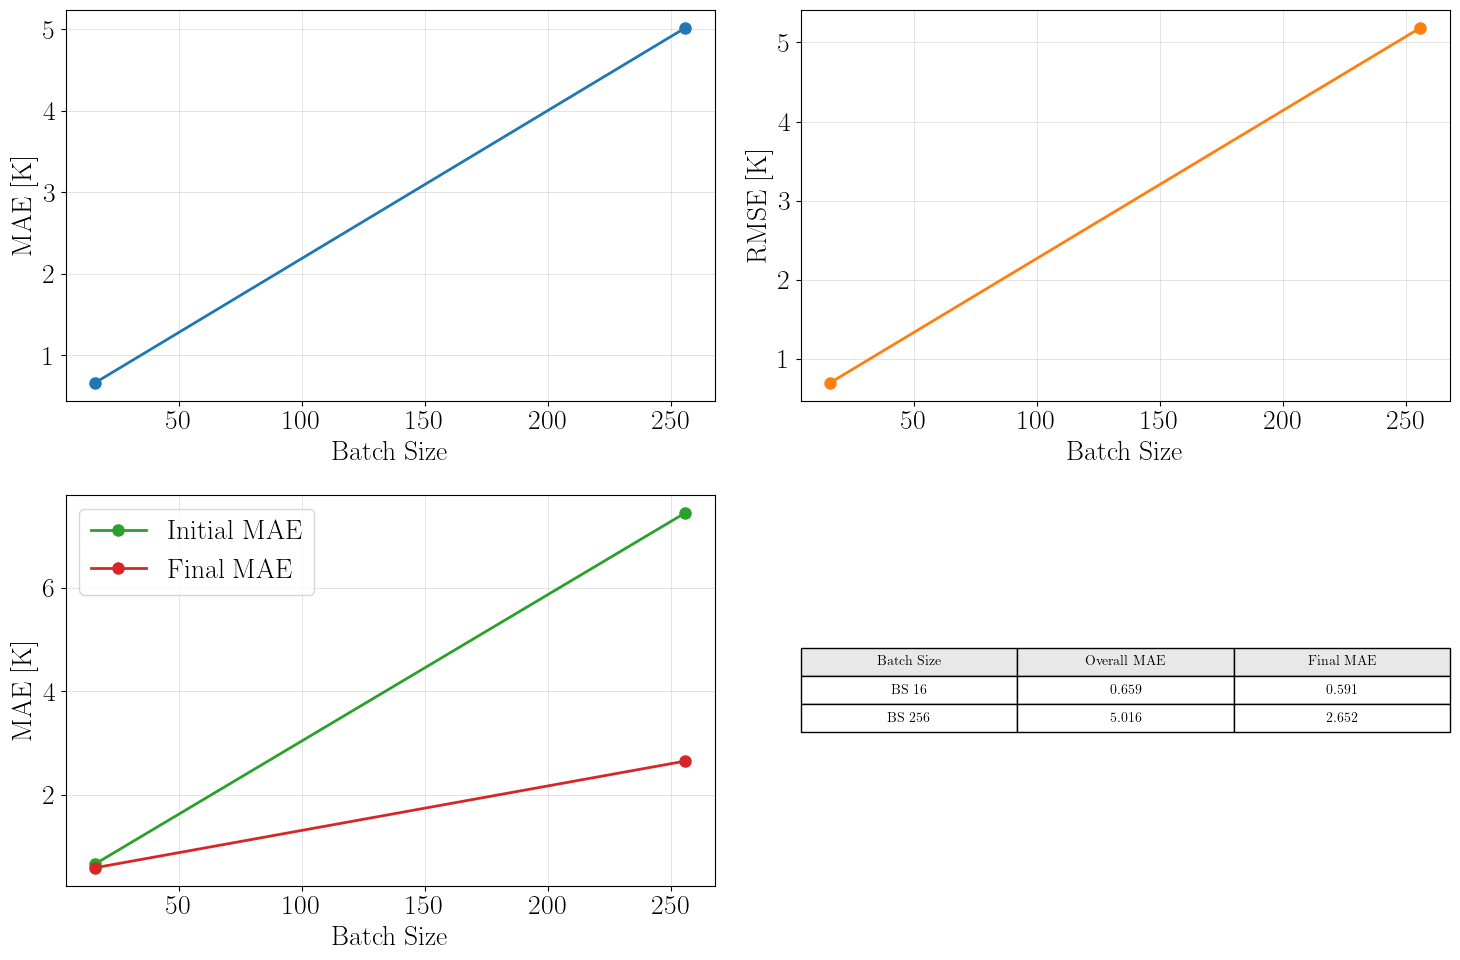

📊 RESUMEN ESTADÍSTICO CONVLSTM
Model                     Batch  Overall MAE  Overall RMSE  Initial MAE  Final MAE   
--------------------------------------------------------------------------------
nt1000_50s_dt1_bs16_h64-64_k3x3 16     0.659        0.696         0.665        0.591       
nt1000_50s_dt1_bs256_h64-64_k3x3 256    5.016        5.186         7.447        2.652       

🏆 MEJORES MODELOS:
   Mejor Overall MAE: nt1000_50s_dt1_bs16_h64-64_k3x3 (BS 16) - 0.659 K
   Mejor Final MAE:   nt1000_50s_dt1_bs16_h64-64_k3x3 (BS 16) - 0.591 K
✅ Análisis completado para 2 modelos
📊 Batch analysis disponible para 2 configuraciones


In [57]:
comparison_results_batch_size, batch_analysis = analyze_batch_size(
    models_dict=custom_models_bs,  # 👈 This should be your loaded models dictionary
    dataset=dataset,
    T_true_all=T_true_all,
    Q_random=Q_random,
    T_interfaces_random=T_interfaces_random,
    T_env_random=T_env_random,
    device=device,
    sequence_length=sequence_length,
    figures_path=FIGURES_PATH,
    save_figures=True
)

# Now you can use the results for further analysis
print(f"✅ Análisis completado para {len(comparison_results_batch_size)} modelos")
print(f"📊 Batch analysis disponible para {len(batch_analysis)} configuraciones")

### Training cases

Tener en cuenta que siempre se usa un rule of thumb con los training cases y los validation cases

In [58]:
def analyze_training_cases_performance_convlstm(convlstm_comparison_results, save_figures=True, 
                                               figures_path='figures/comparison_convlstm'):
    """
    Analiza específicamente el rendimiento de modelos ConvLSTM por número de training cases.
    Extrae training cases de los nombres de modelos y genera visualizaciones comparativas.
    
    Parameters:
        convlstm_comparison_results: dict con resultados de comparación de modelos ConvLSTM
        save_figures: bool, si True guarda las figuras como PDF
        figures_path: str, ruta donde guardar las figuras
        
    Returns:
        dict: análisis de training cases con métricas por modelo
    """
    
    # Extraer métricas para análisis
    training_analysis = {}
    
    for model_name, results in convlstm_comparison_results.items():
        # Extraer número de training cases del nombre del modelo
        # Formato esperado: PCB_ConvLSTM_6ch_nt1000_50s_dt1_bs256_h64-64_k3x3
        if 'nt' in model_name:
            try:
                # Buscar el patrón _nt seguido de números
                import re
                match = re.search(r'_nt(\d+)_', model_name)
                if match:
                    n_train = int(match.group(1))
                else:
                    # Fallback: método anterior
                    n_train = int(model_name.split('nt')[1].split('_')[0])
            except (ValueError, IndexError):
                print(f"⚠️ No se pudo extraer training cases de: {model_name}")
                n_train = 1000  # Por defecto
        else:
            n_train = 1000  # Por defecto
        
        training_analysis[n_train] = {
            'overall_mae': results['overall_mae'],
            'overall_rmse': results['overall_rmse'],
            'overall_std': results['overall_std'],
            'initial_mae': results['mae_per_timestep'][0],
            'final_mae': results['mae_per_timestep'][-1],
            'max_mae': np.max(results['mae_per_timestep']),
            'model_name': model_name
        }
    
    # Mostrar información de extracción para verificar
    print("🔍 Training cases extraídos:")
    for n_train, data in sorted(training_analysis.items()):
        print(f"   📊 NT {n_train}: {data['model_name']}")
    
    n_train_values = sorted(training_analysis.keys())
    overall_mae = [training_analysis[nt]['overall_mae'] for nt in n_train_values]
    overall_rmse = [training_analysis[nt]['overall_rmse'] for nt in n_train_values]
    initial_mae = [training_analysis[nt]['initial_mae'] for nt in n_train_values]
    final_mae = [training_analysis[nt]['final_mae'] for nt in n_train_values]
    
    # =============== FIGURA 1: OVERALL MAE vs TRAINING CASES ===============
    fig1, ax1 = plt.subplots(figsize=(8, 6))
    fig1.patch.set_facecolor('white')
    ax1.set_facecolor('white')
    
    ax1.plot(n_train_values, overall_mae, 'o-', linewidth=2, markersize=8, color='#1f77b4')
    ax1.set_xlabel('Training Cases', color='black')
    ax1.set_ylabel('MAE [K]', color='black')
    ax1.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
    ax1.tick_params(colors='black')
    # Usar escala logarítmica si los valores varían mucho
    if len(n_train_values) > 1 and max(n_train_values) / min(n_train_values) > 10:
        ax1.set_xscale('log')
    
    plt.tight_layout()
    
    if save_figures:
        os.makedirs(figures_path, exist_ok=True)
        plt.savefig(f'{figures_path}/overall_mae_vs_training_cases.pdf', 
                   format='pdf', facecolor='white', bbox_inches='tight')
    
    plt.close()  # 👈 CERRAR SIN MOSTRAR
    
    # =============== FIGURA 2: OVERALL RMSE vs TRAINING CASES ===============
    fig2, ax2 = plt.subplots(figsize=(8, 6))
    fig2.patch.set_facecolor('white')
    ax2.set_facecolor('white')
    
    ax2.plot(n_train_values, overall_rmse, 'o-', linewidth=2, markersize=8, color='#ff7f0e')
    ax2.set_xlabel('Training Cases', color='black')
    ax2.set_ylabel('RMSE [K]', color='black')
    ax2.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
    ax2.tick_params(colors='black')
    if len(n_train_values) > 1 and max(n_train_values) / min(n_train_values) > 10:
        ax2.set_xscale('log')
    
    plt.tight_layout()
    
    if save_figures:
        plt.savefig(f'{figures_path}/overall_rmse_vs_training_cases.pdf', 
                   format='pdf', facecolor='white', bbox_inches='tight')
    
    plt.close()  # 👈 CERRAR SIN MOSTRAR
    
    # =============== FIGURA 3: INITIAL vs FINAL MAE ===============
    fig3, ax3 = plt.subplots(figsize=(8, 6))
    fig3.patch.set_facecolor('white')
    ax3.set_facecolor('white')
    
    ax3.plot(n_train_values, initial_mae, 'o-', linewidth=2, markersize=8, 
             color='#2ca02c', label='Initial MAE')
    ax3.plot(n_train_values, final_mae, 'o-', linewidth=2, markersize=8, 
             color='#d62728', label='Final MAE')
    ax3.set_xlabel('Training Cases', color='black')
    ax3.set_ylabel('MAE [K]', color='black')
    ax3.legend()
    ax3.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
    ax3.tick_params(colors='black')
    if len(n_train_values) > 1 and max(n_train_values) / min(n_train_values) > 10:
        ax3.set_xscale('log')
    
    plt.tight_layout()
    
    if save_figures:
        plt.savefig(f'{figures_path}/initial_vs_final_mae_training.pdf', 
                   format='pdf', facecolor='white', bbox_inches='tight')
    
    plt.close()  # 👈 CERRAR SIN MOSTRAR
    
    # =============== FIGURA 4: TABLA DE RESULTADOS ===============
    fig4, ax4 = plt.subplots(figsize=(10, 6))
    fig4.patch.set_facecolor('white')
    ax4.axis('tight')
    ax4.axis('off')
    
    table_data = []
    for nt in n_train_values:
        table_data.append([
            f"NT {nt}",
            f"{training_analysis[nt]['overall_mae']:.3f}",
            f"{training_analysis[nt]['overall_rmse']:.3f}",
            f"{training_analysis[nt]['initial_mae']:.3f}",
            f"{training_analysis[nt]['final_mae']:.3f}"
        ])
    
    table = ax4.table(cellText=table_data,
                      colLabels=['Training Cases', 'Overall MAE', 'Overall RMSE', 
                               'Initial MAE', 'Final MAE'],
                      cellLoc='center',
                      loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 2)
    
    # Estilo de la tabla
    for (i, j), cell in table.get_celld().items():
        if i == 0:  # Header
            cell.set_text_props(weight='bold')
            cell.set_facecolor('#E8E8E8')
        else:
            cell.set_facecolor('white')
        cell.set_edgecolor('black')
        cell.set_linewidth(1)
    
    plt.tight_layout()
    
    if save_figures:
        plt.savefig(f'{figures_path}/training_analysis_table.pdf', 
                   format='pdf', facecolor='white', bbox_inches='tight')
    
    plt.close()  # 👈 CERRAR SIN MOSTRAR
    
    # =============== FIGURA 5: COMPARACIÓN COMPLETA (4 SUBPLOTS) ===============
    # 👈 ESTA ES LA ÚNICA QUE SE MOSTRARÁ
    fig5, ((ax5a, ax5b), (ax5c, ax5d)) = plt.subplots(2, 2, figsize=(15, 10))
    fig5.patch.set_facecolor('white')
    
    # Subplot 1: Overall MAE
    ax5a.set_facecolor('white')
    ax5a.plot(n_train_values, overall_mae, 'o-', linewidth=2, markersize=8, color='#1f77b4')
    ax5a.set_xlabel('Training Cases', color='black')
    ax5a.set_ylabel('MAE [K]', color='black')
    ax5a.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
    ax5a.tick_params(colors='black')
    if len(n_train_values) > 1 and max(n_train_values) / min(n_train_values) > 10:
        ax5a.set_xscale('log')
    
    # Subplot 2: Overall RMSE
    ax5b.set_facecolor('white')
    ax5b.plot(n_train_values, overall_rmse, 'o-', linewidth=2, markersize=8, color='#ff7f0e')
    ax5b.set_xlabel('Training Cases', color='black')
    ax5b.set_ylabel('RMSE [K]', color='black')
    ax5b.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
    ax5b.tick_params(colors='black')
    if len(n_train_values) > 1 and max(n_train_values) / min(n_train_values) > 10:
        ax5b.set_xscale('log')
    
    # Subplot 3: Initial vs Final MAE
    ax5c.set_facecolor('white')
    ax5c.plot(n_train_values, initial_mae, 'o-', linewidth=2, markersize=8, 
              color='#2ca02c', label='Initial MAE')
    ax5c.plot(n_train_values, final_mae, 'o-', linewidth=2, markersize=8, 
              color='#d62728', label='Final MAE')
    ax5c.set_xlabel('Training Cases', color='black')
    ax5c.set_ylabel('MAE [K]', color='black')
    ax5c.legend()
    ax5c.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
    ax5c.tick_params(colors='black')
    if len(n_train_values) > 1 and max(n_train_values) / min(n_train_values) > 10:
        ax5c.set_xscale('log')
    
    # Subplot 4: Tabla resumida
    ax5d.axis('tight')
    ax5d.axis('off')
    
    table_data_compact = []
    for nt in n_train_values:
        table_data_compact.append([
            f"NT {nt}",
            f"{training_analysis[nt]['overall_mae']:.3f}",
            f"{training_analysis[nt]['final_mae']:.3f}"
        ])
    
    table_compact = ax5d.table(cellText=table_data_compact,
                              colLabels=['Training Cases', 'Overall MAE', 'Final MAE'],
                              cellLoc='center',
                              loc='center')
    table_compact.auto_set_font_size(False)
    table_compact.set_fontsize(10)
    table_compact.scale(1, 1.5)
    
    # Estilo de la tabla compacta
    for (i, j), cell in table_compact.get_celld().items():
        if i == 0:  # Header
            cell.set_text_props(weight='bold')
            cell.set_facecolor('#E8E8E8')
        else:
            cell.set_facecolor('white')
        cell.set_edgecolor('black')
        cell.set_linewidth(1)
    
    plt.tight_layout()
    
    if save_figures:
        plt.savefig(f'{figures_path}/training_analysis_complete.pdf', 
                   format='pdf', facecolor='white', bbox_inches='tight')
    
    plt.show()  # 👈 SOLO MOSTRAR ESTA FIGURA
    
    # =============== RESUMEN ESTADÍSTICO ===============
    print("📊 RESUMEN ESTADÍSTICO CONVLSTM - TRAINING CASES")
    print("="*90)
    print(f"{'Model':<25} {'N_Train':<8} {'Overall MAE':<12} {'Overall RMSE':<13} {'Initial MAE':<12} {'Final MAE':<12}")
    print("-"*90)
    
    # Ordenar por training cases
    sorted_models = sorted(training_analysis.items(), key=lambda x: x[0])
    
    for n_train, metrics in sorted_models:
        print(f"{metrics['model_name']:<25} {n_train:<8} {metrics['overall_mae']:<12.3f} "
              f"{metrics['overall_rmse']:<13.3f} {metrics['initial_mae']:<12.3f} {metrics['final_mae']:<12.3f}")
    
    print("="*90)
    
    # Encontrar el mejor modelo
    if len(sorted_models) > 0:
        best_overall = min(sorted_models, key=lambda x: x[1]['overall_mae'])
        best_final = min(sorted_models, key=lambda x: x[1]['final_mae'])
        
        print(f"\n🏆 MEJORES MODELOS:")
        print(f"   Mejor Overall MAE: {best_overall[1]['model_name']} (NT {best_overall[0]}) - {best_overall[1]['overall_mae']:.3f} K")
        print(f"   Mejor Final MAE:   {best_final[1]['model_name']} (NT {best_final[0]}) - {best_final[1]['final_mae']:.3f} K")
    
    return training_analysis


def analyze_convlstm_models_by_training_cases(models_dict, dataset, T_true_all, Q_random, 
                                            T_interfaces_random, T_env_random, device, 
                                            sequence_length, figures_path, save_figures=True):
    """
    Analiza modelos ConvLSTM enfocándose en comparación por número de training cases.
    
    Args:
        models_dict: diccionario con modelos ConvLSTM {nombre: modelo}
        dataset: dataset para normalización
        T_true_all, Q_random, etc.: datos para análisis
        device: dispositivo de cómputo
        sequence_length: longitud de secuencia
        figures_path: ruta donde guardar figuras
        save_figures: si guardar figuras como PDF
        
    Returns:
        tuple: (comparison_results, training_analysis)
    """
    
    if len(models_dict) == 0:
        print("❌ No hay modelos para analizar.")
        return {}, {}
    
    print(f"🔄 Analizando {len(models_dict)} modelos por training cases...")
    for name in models_dict.keys():
        print(f"   🤖 {name}")
    
    # Ejecutar comparación
    comparison_results = {}
    
    for model_name, model in models_dict.items():
        print(f"\n   🔍 Procesando {model_name}...")
        
        results = calculate_convlstm_error_by_timestep(
            model=model,
            dataset=dataset,
            T_transient_all=T_true_all,
            Q_cases=Q_random,
            T_interfaces_cases=T_interfaces_random,
            T_env_cases=T_env_random,
            device=device,
            sequence_length=sequence_length,
            display=False
        )
        
        comparison_results[model_name] = results
    
    print(f"\n✅ Comparación completada para {len(comparison_results)} modelos")
    
    # Generar análisis específico de training cases
    print("\n📊 Generando análisis de training cases...")
    training_analysis = analyze_training_cases_performance_convlstm(
        comparison_results, 
        save_figures=save_figures,
        figures_path=str(figures_path)
    )
    
    return comparison_results, training_analysis

In [59]:
# Definir los training cases a probar

print(f"🎯 Training cases a analizar: {n_train_it}")

🎯 Training cases a analizar: [10, 100, 200, 250, 500, 1000, 2000, 2500, 4000]


In [60]:
# Cargar modelos con diferentes training cases
custom_models_nt, custom_configs_nt = load_model_by_hyperparameters(
    models_path=MODELS_PATH,
    n_train=n_train_it,  
    time_sim=time_sim_def,
    dt=dt_def,
    batch_sizes=batch_size_def,  # Usar batch size fijo
    hidden_dims=hidden_dims_def,
    kernel_size=kernel_size_def,
    device=device,
    verbose=True
)

print(f"\n📊 Modelos cargados para análisis de training cases: {len(custom_models_nt)}")

🔍 Buscando modelos con patrones:
   📝 PCB_ConvLSTM_6ch_nt500_50s_dt1_bs128_h64-64_k3x3
   📝 PCB_ConvLSTM_6ch_nt1000_50s_dt1_bs128_h64-64_k3x3
   📝 PCB_ConvLSTM_6ch_nt4000_50s_dt1_bs128_h64-64_k3x3
   📝 PCB_ConvLSTM_6ch_nt2000_50s_dt1_bs128_h64-64_k3x3
   📝 PCB_ConvLSTM_6ch_nt2500_50s_dt1_bs128_h64-64_k3x3
   📝 PCB_ConvLSTM_6ch_nt200_50s_dt1_bs128_h64-64_k3x3
   📝 PCB_ConvLSTM_6ch_nt10_50s_dt1_bs128_h64-64_k3x3
   📝 PCB_ConvLSTM_6ch_nt100_50s_dt1_bs128_h64-64_k3x3
   📝 PCB_ConvLSTM_6ch_nt250_50s_dt1_bs128_h64-64_k3x3
🚫 Excluyendo modelos con palabras clave de física: ['phy', 'bnd', 'mse']
📋 Cargando también archivos JSON de configuración
⚠️ No se encontraron modelos que coincidan con los criterios especificados.
📂 Buscando en: c:\Users\ismag\OneDrive\Escritorio\ia_thermal\ismaelgallo\models\ConvLSTM_6ch\stateful_O2O
🔍 Patrones buscados: ['PCB_ConvLSTM_6ch_nt500_50s_dt1_bs128_h64-64_k3x3', 'PCB_ConvLSTM_6ch_nt1000_50s_dt1_bs128_h64-64_k3x3', 'PCB_ConvLSTM_6ch_nt4000_50s_dt1_bs128_h64-64_

In [61]:
# Ejecutar análisis de training cases
comparison_results_training_cases, training_analysis = analyze_convlstm_models_by_training_cases(
    models_dict=custom_models_nt,
    dataset=dataset,
    T_true_all=T_true_all,
    Q_random=Q_random,
    T_interfaces_random=T_interfaces_random,
    T_env_random=T_env_random,
    device=device,
    sequence_length=sequence_length,
    figures_path=FIGURES_PATH,
    save_figures=True
)

# Mostrar resultados
print(f"✅ Análisis de training cases completado para {len(comparison_results_training_cases)} modelos")
print(f"📊 Training analysis disponible para {len(training_analysis)} configuraciones")

❌ No hay modelos para analizar.
✅ Análisis de training cases completado para 0 modelos
📊 Training analysis disponible para 0 configuraciones


### Simulation time

In [62]:
def analyze_simulation_time_performance_convlstm(convlstm_comparison_results, save_figures=True, 
                                                figures_path='figures/comparison_convlstm'):
    """
    Analiza específicamente el rendimiento de modelos ConvLSTM por tiempo de simulación.
    Extrae tiempo de simulación de los nombres de modelos y genera visualizaciones comparativas.
    
    Parameters:
        convlstm_comparison_results: dict con resultados de comparación de modelos ConvLSTM
        save_figures: bool, si True guarda las figuras como PDF
        figures_path: str, ruta donde guardar las figuras
        
    Returns:
        dict: análisis de tiempos de simulación con métricas por modelo
    """
    
    # Extraer métricas para análisis
    time_analysis = {}
    
    for model_name, results in convlstm_comparison_results.items():
        # Extraer tiempo de simulación del nombre del modelo
        # Formato esperado: PCB_ConvLSTM_6ch_nt1000_50s_dt1_bs16_h64-64_k3x3
        if 's_' in model_name or model_name.endswith('s'):
            try:
                # Buscar el patrón de números seguidos de 's'
                import re
                match = re.search(r'_(\d+)s_', model_name)
                if match:
                    time_sim = int(match.group(1))
                else:
                    # Fallback: buscar patrón al final
                    match = re.search(r'_(\d+)s$', model_name)
                    if match:
                        time_sim = int(match.group(1))
                    else:
                        # Método anterior como último recurso
                        time_parts = [part for part in model_name.split('_') if 's' in part and part.replace('s', '').isdigit()]
                        if time_parts:
                            time_sim = int(time_parts[0].replace('s', ''))
                        else:
                            time_sim = 50  # Por defecto
            except (ValueError, IndexError):
                print(f"⚠️ No se pudo extraer tiempo de simulación de: {model_name}")
                time_sim = 50  # Por defecto
        else:
            time_sim = 50  # Por defecto
        
        time_analysis[time_sim] = {
            'overall_mae': results['overall_mae'],
            'overall_rmse': results['overall_rmse'],
            'overall_std': results['overall_std'],
            'initial_mae': results['mae_per_timestep'][0],
            'final_mae': results['mae_per_timestep'][-1],
            'max_mae': np.max(results['mae_per_timestep']),
            'model_name': model_name
        }
    
    # Mostrar información de extracción para verificar
    print("🔍 Tiempos de simulación extraídos:")
    for time_sim, data in sorted(time_analysis.items()):
        print(f"   ⏱️ {time_sim}s: {data['model_name']}")
    
    time_sim_values = sorted(time_analysis.keys())
    overall_mae = [time_analysis[ts]['overall_mae'] for ts in time_sim_values]
    overall_rmse = [time_analysis[ts]['overall_rmse'] for ts in time_sim_values]
    initial_mae = [time_analysis[ts]['initial_mae'] for ts in time_sim_values]
    final_mae = [time_analysis[ts]['final_mae'] for ts in time_sim_values]
    
    # =============== FIGURA 1: OVERALL MAE vs SIMULATION TIME ===============
    fig1, ax1 = plt.subplots(figsize=(8, 6))
    fig1.patch.set_facecolor('white')
    ax1.set_facecolor('white')
    
    ax1.plot(time_sim_values, overall_mae, 'o-', linewidth=2, markersize=8, color='#1f77b4')
    ax1.set_xlabel('Simulation Time [s]', color='black')
    ax1.set_ylabel('MAE [K]', color='black')
    ax1.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
    ax1.tick_params(colors='black')
    # Usar escala logarítmica si los valores varían mucho
    if len(time_sim_values) > 1 and max(time_sim_values) / min(time_sim_values) > 10:
        ax1.set_xscale('log')
    
    plt.tight_layout()
    
    if save_figures:
        os.makedirs(figures_path, exist_ok=True)
        plt.savefig(f'{figures_path}/overall_mae_vs_simulation_time.pdf', 
                   format='pdf', facecolor='white', bbox_inches='tight')
    
    plt.close()  # 👈 CERRAR SIN MOSTRAR
    
    # =============== FIGURA 2: OVERALL RMSE vs SIMULATION TIME ===============
    fig2, ax2 = plt.subplots(figsize=(8, 6))
    fig2.patch.set_facecolor('white')
    ax2.set_facecolor('white')
    
    ax2.plot(time_sim_values, overall_rmse, 'o-', linewidth=2, markersize=8, color='#ff7f0e')
    ax2.set_xlabel('Simulation Time [s]', color='black')
    ax2.set_ylabel('RMSE [K]', color='black')
    ax2.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
    ax2.tick_params(colors='black')
    if len(time_sim_values) > 1 and max(time_sim_values) / min(time_sim_values) > 10:
        ax2.set_xscale('log')
    
    plt.tight_layout()
    
    if save_figures:
        plt.savefig(f'{figures_path}/overall_rmse_vs_simulation_time.pdf', 
                   format='pdf', facecolor='white', bbox_inches='tight')
    
    plt.close()  # 👈 CERRAR SIN MOSTRAR
    
    # =============== FIGURA 3: INITIAL vs FINAL MAE ===============
    fig3, ax3 = plt.subplots(figsize=(8, 6))
    fig3.patch.set_facecolor('white')
    ax3.set_facecolor('white')
    
    ax3.plot(time_sim_values, initial_mae, 'o-', linewidth=2, markersize=8, 
             color='#2ca02c', label='Initial MAE')
    ax3.plot(time_sim_values, final_mae, 'o-', linewidth=2, markersize=8, 
             color='#d62728', label='Final MAE')
    ax3.set_xlabel('Simulation Time [s]', color='black')
    ax3.set_ylabel('MAE [K]', color='black')
    ax3.legend()
    ax3.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
    ax3.tick_params(colors='black')
    if len(time_sim_values) > 1 and max(time_sim_values) / min(time_sim_values) > 10:
        ax3.set_xscale('log')
    
    plt.tight_layout()
    
    if save_figures:
        plt.savefig(f'{figures_path}/initial_vs_final_mae_simulation_time.pdf', 
                   format='pdf', facecolor='white', bbox_inches='tight')
    
    plt.close()  # 👈 CERRAR SIN MOSTRAR
    
    # =============== FIGURA 4: TABLA DE RESULTADOS ===============
    fig4, ax4 = plt.subplots(figsize=(10, 6))
    fig4.patch.set_facecolor('white')
    ax4.axis('tight')
    ax4.axis('off')
    
    table_data = []
    for ts in time_sim_values:
        table_data.append([
            f"{ts}s",
            f"{time_analysis[ts]['overall_mae']:.3f}",
            f"{time_analysis[ts]['overall_rmse']:.3f}",
            f"{time_analysis[ts]['initial_mae']:.3f}",
            f"{time_analysis[ts]['final_mae']:.3f}"
        ])
    
    table = ax4.table(cellText=table_data,
                      colLabels=['Simulation Time', 'Overall MAE', 'Overall RMSE', 
                               'Initial MAE', 'Final MAE'],
                      cellLoc='center',
                      loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 2)
    
    # Estilo de la tabla
    for (i, j), cell in table.get_celld().items():
        if i == 0:  # Header
            cell.set_text_props(weight='bold')
            cell.set_facecolor('#E8E8E8')
        else:
            cell.set_facecolor('white')
        cell.set_edgecolor('black')
        cell.set_linewidth(1)
    
    plt.tight_layout()
    
    if save_figures:
        plt.savefig(f'{figures_path}/simulation_time_analysis_table.pdf', 
                   format='pdf', facecolor='white', bbox_inches='tight')
    
    plt.close()  # 👈 CERRAR SIN MOSTRAR
    
    # =============== FIGURA 5: COMPARACIÓN COMPLETA (4 SUBPLOTS) ===============
    # 👈 ESTA ES LA ÚNICA QUE SE MOSTRARÁ
    fig5, ((ax5a, ax5b), (ax5c, ax5d)) = plt.subplots(2, 2, figsize=(15, 10))
    fig5.patch.set_facecolor('white')
    
    # Subplot 1: Overall MAE
    ax5a.set_facecolor('white')
    ax5a.plot(time_sim_values, overall_mae, 'o-', linewidth=2, markersize=8, color='#1f77b4')
    ax5a.set_xlabel('Simulation Time [s]', color='black')
    ax5a.set_ylabel('MAE [K]', color='black')
    ax5a.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
    ax5a.tick_params(colors='black')
    if len(time_sim_values) > 1 and max(time_sim_values) / min(time_sim_values) > 10:
        ax5a.set_xscale('log')
    
    # Subplot 2: Overall RMSE
    ax5b.set_facecolor('white')
    ax5b.plot(time_sim_values, overall_rmse, 'o-', linewidth=2, markersize=8, color='#ff7f0e')
    ax5b.set_xlabel('Simulation Time [s]', color='black')
    ax5b.set_ylabel('RMSE [K]', color='black')
    ax5b.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
    ax5b.tick_params(colors='black')
    if len(time_sim_values) > 1 and max(time_sim_values) / min(time_sim_values) > 10:
        ax5b.set_xscale('log')
    
    # Subplot 3: Initial vs Final MAE
    ax5c.set_facecolor('white')
    ax5c.plot(time_sim_values, initial_mae, 'o-', linewidth=2, markersize=8, 
              color='#2ca02c', label='Initial MAE')
    ax5c.plot(time_sim_values, final_mae, 'o-', linewidth=2, markersize=8, 
              color='#d62728', label='Final MAE')
    ax5c.set_xlabel('Simulation Time [s]', color='black')
    ax5c.set_ylabel('MAE [K]', color='black')
    ax5c.legend()
    ax5c.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
    ax5c.tick_params(colors='black')
    if len(time_sim_values) > 1 and max(time_sim_values) / min(time_sim_values) > 10:
        ax5c.set_xscale('log')
    
    # Subplot 4: Tabla resumida
    ax5d.axis('tight')
    ax5d.axis('off')
    
    table_data_compact = []
    for ts in time_sim_values:
        table_data_compact.append([
            f"{ts}s",
            f"{time_analysis[ts]['overall_mae']:.3f}",
            f"{time_analysis[ts]['final_mae']:.3f}"
        ])
    
    table_compact = ax5d.table(cellText=table_data_compact,
                              colLabels=['Simulation Time', 'Overall MAE', 'Final MAE'],
                              cellLoc='center',
                              loc='center')
    table_compact.auto_set_font_size(False)
    table_compact.set_fontsize(10)
    table_compact.scale(1, 1.5)
    
    # Estilo de la tabla compacta
    for (i, j), cell in table_compact.get_celld().items():
        if i == 0:  # Header
            cell.set_text_props(weight='bold')
            cell.set_facecolor('#E8E8E8')
        else:
            cell.set_facecolor('white')
        cell.set_edgecolor('black')
        cell.set_linewidth(1)
    
    plt.tight_layout()
    
    if save_figures:
        plt.savefig(f'{figures_path}/simulation_time_analysis_complete.pdf', 
                   format='pdf', facecolor='white', bbox_inches='tight')
    
    plt.show()  # 👈 SOLO MOSTRAR ESTA FIGURA
    
    # =============== RESUMEN ESTADÍSTICO ===============
    print("📊 RESUMEN ESTADÍSTICO CONVLSTM - SIMULATION TIME")
    print("="*90)
    print(f"{'Model':<25} {'Time_Sim':<8} {'Overall MAE':<12} {'Overall RMSE':<13} {'Initial MAE':<12} {'Final MAE':<12}")
    print("-"*90)
    
    # Ordenar por tiempo de simulación
    sorted_models = sorted(time_analysis.items(), key=lambda x: x[0])
    
    for time_sim, metrics in sorted_models:
        print(f"{metrics['model_name']:<25} {time_sim:<8}s {metrics['overall_mae']:<12.3f} "
              f"{metrics['overall_rmse']:<13.3f} {metrics['initial_mae']:<12.3f} {metrics['final_mae']:<12.3f}")
    
    print("="*90)
    
    # Encontrar el mejor modelo
    if len(sorted_models) > 0:
        best_overall = min(sorted_models, key=lambda x: x[1]['overall_mae'])
        best_final = min(sorted_models, key=lambda x: x[1]['final_mae'])
        
        print(f"\n🏆 MEJORES MODELOS:")
        print(f"   Mejor Overall MAE: {best_overall[1]['model_name']} ({best_overall[0]}s) - {best_overall[1]['overall_mae']:.3f} K")
        print(f"   Mejor Final MAE:   {best_final[1]['model_name']} ({best_final[0]}s) - {best_final[1]['final_mae']:.3f} K")
    
    return time_analysis


def analyze_convlstm_models_by_simulation_time(models_dict, dataset, T_true_all, Q_random, 
                                             T_interfaces_random, T_env_random, device, 
                                             sequence_length, figures_path, save_figures=True):
    """
    Analiza modelos ConvLSTM enfocándose en comparación por tiempo de simulación.
    
    Args:
        models_dict: diccionario con modelos ConvLSTM {nombre: modelo}
        dataset: dataset para normalización
        T_true_all, Q_random, etc.: datos para análisis
        device: dispositivo de cómputo
        sequence_length: longitud de secuencia
        figures_path: ruta donde guardar figuras
        save_figures: si guardar figuras como PDF
        
    Returns:
        tuple: (comparison_results, time_analysis)
    """
    
    if len(models_dict) == 0:
        print("❌ No hay modelos para analizar.")
        return {}, {}
    
    print(f"🔄 Analizando {len(models_dict)} modelos por tiempo de simulación...")
    for name in models_dict.keys():
        print(f"   🤖 {name}")
    
    # Ejecutar comparación
    comparison_results = {}
    
    for model_name, model in models_dict.items():
        print(f"\n   🔍 Procesando {model_name}...")
        
        results = calculate_convlstm_error_by_timestep(
            model=model,
            dataset=dataset,
            T_transient_all=T_true_all,
            Q_cases=Q_random,
            T_interfaces_cases=T_interfaces_random,
            T_env_cases=T_env_random,
            device=device,
            sequence_length=sequence_length,
            display=False
        )
        
        comparison_results[model_name] = results
    
    print(f"\n✅ Comparación completada para {len(comparison_results)} modelos")
    
    # Generar análisis específico de tiempo de simulación
    print("\n📊 Generando análisis de tiempo de simulación...")
    time_analysis = analyze_simulation_time_performance_convlstm(
        comparison_results, 
        save_figures=save_figures,
        figures_path=str(figures_path)
    )
    
    return comparison_results, time_analysis


def analyze_simulation_time(models_dict, dataset, T_true_all, Q_random, 
                          T_interfaces_random, T_env_random, device, 
                          sequence_length, figures_path, save_figures=True):
    """
    Función genérica para analizar el efecto del tiempo de simulación en los modelos.
    
    Args:
        models_dict: diccionario con modelos {nombre: modelo}
        dataset: dataset para normalización
        T_true_all, Q_random, etc.: datos para análisis
        device: dispositivo de cómputo
        sequence_length: longitud de secuencia
        figures_path: ruta donde guardar figuras
        save_figures: si guardar figuras como PDF
        
    Returns:
        tuple: (comparison_results, time_analysis)
    """
    
    if len(models_dict) == 0:
        print("❌ No hay modelos para analizar.")
        return {}, {}
    
    print(f"🔄 Analizando {len(models_dict)} modelos por tiempo de simulación...")
    for name in models_dict.keys():
        print(f"   🤖 {name}")
    
    # Ejecutar comparación
    comparison_results = {}
    
    for model_name, model in models_dict.items():
        print(f"\n   🔍 Procesando {model_name}...")
        
        results = calculate_convlstm_error_by_timestep(
            model=model,
            dataset=dataset,
            T_transient_all=T_true_all,
            Q_cases=Q_random,
            T_interfaces_cases=T_interfaces_random,
            T_env_cases=T_env_random,
            device=device,
            sequence_length=sequence_length,
            display=False
        )
        
        comparison_results[model_name] = results
    
    print(f"\n✅ Comparación completada para {len(comparison_results)} modelos")
    
    # Generar análisis
    print("\n📊 Generando análisis...")
    time_analysis = analyze_simulation_time_performance_convlstm(
        comparison_results, 
        save_figures=save_figures,
        figures_path=str(figures_path)
    )
    
    return comparison_results, time_analysis

In [63]:
# Definir los tiempos de simulación a probar

print(f"⏱️ Tiempos de simulación a analizar: {time_sim_it}")

⏱️ Tiempos de simulación a analizar: [25, 50, 100, 200, 500, 1000]


In [64]:
# Cargar modelos con diferentes tiempos de simulación
custom_models_time, custom_configs_time = load_model_by_hyperparameters(
    models_path=MODELS_PATH,
    n_train=n_train_def,      # Usar n_train fijo
    time_sim=time_sim_it,     # Variable
    dt=dt_def,
    batch_sizes=batch_size_def,  # Usar batch size fijo
    hidden_dims=hidden_dims_def,
    kernel_size=kernel_size_def,
    device=device,
    verbose=True
)

print(f"\n📊 Modelos cargados para análisis de tiempo de simulación: {len(custom_models_time)}")

🔍 Buscando modelos con patrones:
   📝 PCB_ConvLSTM_6ch_nt1000_50s_dt1_bs128_h64-64_k3x3
   📝 PCB_ConvLSTM_6ch_nt1000_200s_dt1_bs128_h64-64_k3x3
   📝 PCB_ConvLSTM_6ch_nt1000_500s_dt1_bs128_h64-64_k3x3
   📝 PCB_ConvLSTM_6ch_nt1000_100s_dt1_bs128_h64-64_k3x3
   📝 PCB_ConvLSTM_6ch_nt1000_1000s_dt1_bs128_h64-64_k3x3
   📝 PCB_ConvLSTM_6ch_nt1000_25s_dt1_bs128_h64-64_k3x3
🚫 Excluyendo modelos con palabras clave de física: ['phy', 'bnd', 'mse']
📋 Cargando también archivos JSON de configuración
⚠️ No se encontraron modelos que coincidan con los criterios especificados.
📂 Buscando en: c:\Users\ismag\OneDrive\Escritorio\ia_thermal\ismaelgallo\models\ConvLSTM_6ch\stateful_O2O
🔍 Patrones buscados: ['PCB_ConvLSTM_6ch_nt1000_50s_dt1_bs128_h64-64_k3x3', 'PCB_ConvLSTM_6ch_nt1000_200s_dt1_bs128_h64-64_k3x3', 'PCB_ConvLSTM_6ch_nt1000_500s_dt1_bs128_h64-64_k3x3', 'PCB_ConvLSTM_6ch_nt1000_100s_dt1_bs128_h64-64_k3x3', 'PCB_ConvLSTM_6ch_nt1000_1000s_dt1_bs128_h64-64_k3x3']...

📋 Archivos disponibles en c:\Us

In [65]:
# Ejecutar análisis de tiempo de simulación
comparison_results_simulation_time, simulation_time_analysis = analyze_convlstm_models_by_simulation_time(
    models_dict=custom_models_time,
    dataset=dataset,
    T_true_all=T_true_all,
    Q_random=Q_random,
    T_interfaces_random=T_interfaces_random,
    T_env_random=T_env_random,
    device=device,
    sequence_length=sequence_length,
    figures_path=FIGURES_PATH,
    save_figures=True
)

# Mostrar resultados
print(f"✅ Análisis de tiempo de simulación completado para {len(comparison_results_simulation_time)} modelos")
print(f"📊 Simulation time analysis disponible para {len(simulation_time_analysis)} configuraciones")

❌ No hay modelos para analizar.
✅ Análisis de tiempo de simulación completado para 0 modelos
📊 Simulation time analysis disponible para 0 configuraciones


### Hidden dim

In [66]:
def analyze_hidden_dims_performance_convlstm(convlstm_comparison_results, save_figures=True, 
                                           figures_path='figures/comparison_convlstm'):
    """
    Analiza específicamente el rendimiento de modelos ConvLSTM por dimensiones ocultas.
    Extrae hidden dimensions de los nombres de modelos y genera visualizaciones comparativas.
    
    Parameters:
        convlstm_comparison_results: dict con resultados de comparación de modelos ConvLSTM
        save_figures: bool, si True guarda las figuras como PDF
        figures_path: str, ruta donde guardar las figuras
        
    Returns:
        dict: análisis de hidden dimensions con métricas por modelo
    """
    
    # Extraer métricas para análisis
    hidden_analysis = {}
    
    for model_name, results in convlstm_comparison_results.items():
        # Extraer hidden dimensions del nombre del modelo
        # Formato esperado: PCB_ConvLSTM_6ch_nt1000_50s_dt1_bs16_h64-64_k3x3
        if '_h' in model_name:
            try:
                # Buscar el patrón _h seguido de números y guiones
                import re
                match = re.search(r'_h([0-9\-]+)_', model_name)
                if match:
                    h_string = match.group(1)
                    hidden_dims = tuple(int(x) for x in h_string.split('-'))
                else:
                    # Fallback: método anterior
                    h_part = model_name.split('_h')[1].split('_')[0]
                    hidden_dims = tuple(int(x) for x in h_part.split('-'))
            except (ValueError, IndexError):
                print(f"⚠️ No se pudo extraer hidden dimensions de: {model_name}")
                hidden_dims = (64, 64)  # Por defecto
        else:
            hidden_dims = (64, 64)  # Por defecto
        
        # Crear clave descriptiva para la arquitectura
        arch_key = f"{hidden_dims[0]}x{len(hidden_dims)}"  # ej: "64x2", "128x3"
        arch_full = f"[{', '.join(map(str, hidden_dims))}]"  # ej: "[64, 64]"
        
        hidden_analysis[hidden_dims] = {
            'overall_mae': results['overall_mae'],
            'overall_rmse': results['overall_rmse'],
            'overall_std': results['overall_std'],
            'initial_mae': results['mae_per_timestep'][0],
            'final_mae': results['mae_per_timestep'][-1],
            'max_mae': np.max(results['mae_per_timestep']),
            'model_name': model_name,
            'arch_key': arch_key,
            'arch_full': arch_full,
            'total_params': sum(hidden_dims) * len(hidden_dims)  # Aproximación de parámetros
        }
    
    # Mostrar información de extracción para verificar
    print("🔍 Hidden dimensions extraídas:")
    for hidden_dims, data in sorted(hidden_analysis.items()):
        print(f"   🧠 {data['arch_full']}: {data['model_name']}")
    
    # Ordenar por complejidad (suma de dimensiones)
    sorted_archs = sorted(hidden_analysis.items(), key=lambda x: sum(x[0]))
    
    arch_labels = [data['arch_full'] for _, data in sorted_archs]
    overall_mae = [data['overall_mae'] for _, data in sorted_archs]
    overall_rmse = [data['overall_rmse'] for _, data in sorted_archs]
    initial_mae = [data['initial_mae'] for _, data in sorted_archs]
    final_mae = [data['final_mae'] for _, data in sorted_archs]
    
    # =============== FIGURA 1: OVERALL MAE vs HIDDEN DIMENSIONS ===============
    fig1, ax1 = plt.subplots(figsize=(10, 6))
    fig1.patch.set_facecolor('white')
    ax1.set_facecolor('white')
    
    x_pos = range(len(arch_labels))
    ax1.plot(x_pos, overall_mae, 'o-', linewidth=2, markersize=8, color='#1f77b4')
    ax1.set_xlabel('Architecture', color='black')
    ax1.set_ylabel('MAE [K]', color='black')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(arch_labels, rotation=45)
    ax1.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
    ax1.tick_params(colors='black')
    
    plt.tight_layout()
    
    if save_figures:
        os.makedirs(figures_path, exist_ok=True)
        plt.savefig(f'{figures_path}/overall_mae_vs_hidden_dims.pdf', 
                   format='pdf', facecolor='white', bbox_inches='tight')
    
    plt.close()  # 👈 CERRAR SIN MOSTRAR
    
    # =============== FIGURA 2: OVERALL RMSE vs HIDDEN DIMENSIONS ===============
    fig2, ax2 = plt.subplots(figsize=(10, 6))
    fig2.patch.set_facecolor('white')
    ax2.set_facecolor('white')
    
    ax2.plot(x_pos, overall_rmse, 'o-', linewidth=2, markersize=8, color='#ff7f0e')
    ax2.set_xlabel('Architecture', color='black')
    ax2.set_ylabel('RMSE [K]', color='black')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(arch_labels, rotation=45)
    ax2.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
    ax2.tick_params(colors='black')
    
    plt.tight_layout()
    
    if save_figures:
        plt.savefig(f'{figures_path}/overall_rmse_vs_hidden_dims.pdf', 
                   format='pdf', facecolor='white', bbox_inches='tight')
    
    plt.close()  # 👈 CERRAR SIN MOSTRAR
    
    # =============== FIGURA 3: INITIAL vs FINAL MAE ===============
    fig3, ax3 = plt.subplots(figsize=(10, 6))
    fig3.patch.set_facecolor('white')
    ax3.set_facecolor('white')
    
    ax3.plot(x_pos, initial_mae, 'o-', linewidth=2, markersize=8, 
             color='#2ca02c', label='Initial MAE')
    ax3.plot(x_pos, final_mae, 'o-', linewidth=2, markersize=8, 
             color='#d62728', label='Final MAE')
    ax3.set_xlabel('Architecture', color='black')
    ax3.set_ylabel('MAE [K]', color='black')
    ax3.set_xticks(x_pos)
    ax3.set_xticklabels(arch_labels, rotation=45)
    ax3.legend()
    ax3.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
    ax3.tick_params(colors='black')
    
    plt.tight_layout()
    
    if save_figures:
        plt.savefig(f'{figures_path}/initial_vs_final_mae_hidden_dims.pdf', 
                   format='pdf', facecolor='white', bbox_inches='tight')
    
    plt.close()  # 👈 CERRAR SIN MOSTRAR
    
    # =============== FIGURA 4: TABLA DE RESULTADOS ===============
    fig4, ax4 = plt.subplots(figsize=(12, 6))
    fig4.patch.set_facecolor('white')
    ax4.axis('tight')
    ax4.axis('off')
    
    table_data = []
    for hidden_dims, data in sorted_archs:
        table_data.append([
            data['arch_full'],
            f"{data['overall_mae']:.3f}",
            f"{data['overall_rmse']:.3f}",
            f"{data['initial_mae']:.3f}",
            f"{data['final_mae']:.3f}"
        ])
    
    table = ax4.table(cellText=table_data,
                      colLabels=['Architecture', 'Overall MAE', 'Overall RMSE', 
                               'Initial MAE', 'Final MAE'],
                      cellLoc='center',
                      loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 2)
    
    # Estilo de la tabla
    for (i, j), cell in table.get_celld().items():
        if i == 0:  # Header
            cell.set_text_props(weight='bold')
            cell.set_facecolor('#E8E8E8')
        else:
            cell.set_facecolor('white')
        cell.set_edgecolor('black')
        cell.set_linewidth(1)
    
    plt.tight_layout()
    
    if save_figures:
        plt.savefig(f'{figures_path}/hidden_dims_analysis_table.pdf', 
                   format='pdf', facecolor='white', bbox_inches='tight')
    
    plt.close()  # 👈 CERRAR SIN MOSTRAR
    
    # =============== FIGURA 5: COMPARACIÓN COMPLETA (4 SUBPLOTS) ===============
    # 👈 ESTA ES LA ÚNICA QUE SE MOSTRARÁ
    fig5, ((ax5a, ax5b), (ax5c, ax5d)) = plt.subplots(2, 2, figsize=(15, 10))
    fig5.patch.set_facecolor('white')
    
    # Subplot 1: Overall MAE
    ax5a.set_facecolor('white')
    ax5a.plot(x_pos, overall_mae, 'o-', linewidth=2, markersize=8, color='#1f77b4')
    ax5a.set_xlabel('Architecture', color='black')
    ax5a.set_ylabel('MAE [K]', color='black')
    ax5a.set_xticks(x_pos)
    ax5a.set_xticklabels(arch_labels, rotation=45)
    ax5a.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
    ax5a.tick_params(colors='black')
    
    # Subplot 2: Overall RMSE
    ax5b.set_facecolor('white')
    ax5b.plot(x_pos, overall_rmse, 'o-', linewidth=2, markersize=8, color='#ff7f0e')
    ax5b.set_xlabel('Architecture', color='black')
    ax5b.set_ylabel('RMSE [K]', color='black')
    ax5b.set_xticks(x_pos)
    ax5b.set_xticklabels(arch_labels, rotation=45)
    ax5b.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
    ax5b.tick_params(colors='black')
    
    # Subplot 3: Initial vs Final MAE
    ax5c.set_facecolor('white')
    ax5c.plot(x_pos, initial_mae, 'o-', linewidth=2, markersize=8, 
              color='#2ca02c', label='Initial MAE')
    ax5c.plot(x_pos, final_mae, 'o-', linewidth=2, markersize=8, 
              color='#d62728', label='Final MAE')
    ax5c.set_xlabel('Architecture', color='black')
    ax5c.set_ylabel('MAE [K]', color='black')
    ax5c.set_xticks(x_pos)
    ax5c.set_xticklabels(arch_labels, rotation=45)
    ax5c.legend()
    ax5c.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
    ax5c.tick_params(colors='black')
    
    # Subplot 4: Tabla resumida
    ax5d.axis('tight')
    ax5d.axis('off')
    
    table_data_compact = []
    for hidden_dims, data in sorted_archs:
        table_data_compact.append([
            data['arch_full'],
            f"{data['overall_mae']:.3f}",
            f"{data['final_mae']:.3f}"
        ])
    
    table_compact = ax5d.table(cellText=table_data_compact,
                              colLabels=['Architecture', 'Overall MAE', 'Final MAE'],
                              cellLoc='center',
                              loc='center')
    table_compact.auto_set_font_size(False)
    table_compact.set_fontsize(10)
    table_compact.scale(1, 1.5)
    
    # Estilo de la tabla compacta
    for (i, j), cell in table_compact.get_celld().items():
        if i == 0:  # Header
            cell.set_text_props(weight='bold')
            cell.set_facecolor('#E8E8E8')
        else:
            cell.set_facecolor('white')
        cell.set_edgecolor('black')
        cell.set_linewidth(1)
    
    plt.tight_layout()
    
    if save_figures:
        plt.savefig(f'{figures_path}/hidden_dims_analysis_complete.pdf', 
                   format='pdf', facecolor='white', bbox_inches='tight')
    
    plt.show()  # 👈 SOLO MOSTRAR ESTA FIGURA
    
    # =============== RESUMEN ESTADÍSTICO ===============
    print("📊 RESUMEN ESTADÍSTICO CONVLSTM - HIDDEN DIMENSIONS")
    print("="*95)
    print(f"{'Model':<25} {'Architecture':<12} {'Overall MAE':<12} {'Overall RMSE':<13} {'Initial MAE':<12} {'Final MAE':<12}")
    print("-"*95)
    
    # Ordenar por hidden dimensions
    for hidden_dims, metrics in sorted_archs:
        print(f"{metrics['model_name']:<25} {metrics['arch_full']:<12} {metrics['overall_mae']:<12.3f} "
              f"{metrics['overall_rmse']:<13.3f} {metrics['initial_mae']:<12.3f} {metrics['final_mae']:<12.3f}")
    
    print("="*95)
    
    # Encontrar el mejor modelo
    if len(sorted_archs) > 0:
        best_overall = min(sorted_archs, key=lambda x: x[1]['overall_mae'])
        best_final = min(sorted_archs, key=lambda x: x[1]['final_mae'])
        
        print(f"\n🏆 MEJORES MODELOS:")
        print(f"   Mejor Overall MAE: {best_overall[1]['model_name']} {best_overall[1]['arch_full']} - {best_overall[1]['overall_mae']:.3f} K")
        print(f"   Mejor Final MAE:   {best_final[1]['model_name']} {best_final[1]['arch_full']} - {best_final[1]['final_mae']:.3f} K")
    
    return dict(hidden_analysis)  # Convertir claves tuple a dict normal


def analyze_convlstm_models_by_hidden_dims(models_dict, dataset, T_true_all, Q_random, 
                                         T_interfaces_random, T_env_random, device, 
                                         sequence_length, figures_path, save_figures=True):
    """
    Analiza modelos ConvLSTM enfocándose en comparación por dimensiones ocultas.
    
    Args:
        models_dict: diccionario con modelos ConvLSTM {nombre: modelo}
        dataset: dataset para normalización
        T_true_all, Q_random, etc.: datos para análisis
        device: dispositivo de cómputo
        sequence_length: longitud de secuencia
        figures_path: ruta donde guardar figuras
        save_figures: si guardar figuras como PDF
        
    Returns:
        tuple: (comparison_results, hidden_dims_analysis)
    """
    
    if len(models_dict) == 0:
        print("❌ No hay modelos para analizar.")
        return {}, {}
    
    print(f"🔄 Analizando {len(models_dict)} modelos por dimensiones ocultas...")
    for name in models_dict.keys():
        print(f"   🤖 {name}")
    
    # Ejecutar comparación
    comparison_results = {}
    
    for model_name, model in models_dict.items():
        print(f"\n   🔍 Procesando {model_name}...")
        
        results = calculate_convlstm_error_by_timestep(
            model=model,
            dataset=dataset,
            T_transient_all=T_true_all,
            Q_cases=Q_random,
            T_interfaces_cases=T_interfaces_random,
            T_env_cases=T_env_random,
            device=device,
            sequence_length=sequence_length,
            display=False
        )
        
        comparison_results[model_name] = results
    
    print(f"\n✅ Comparación completada para {len(comparison_results)} modelos")
    
    # Generar análisis específico de dimensiones ocultas
    print("\n📊 Generando análisis de dimensiones ocultas...")
    hidden_dims_analysis = analyze_hidden_dims_performance_convlstm(
        comparison_results, 
        save_figures=save_figures,
        figures_path=str(figures_path)
    )
    
    return comparison_results, hidden_dims_analysis


def analyze_hidden_dims(models_dict, dataset, T_true_all, Q_random, 
                       T_interfaces_random, T_env_random, device, 
                       sequence_length, figures_path, save_figures=True):
    """
    Función genérica para analizar el efecto de las dimensiones ocultas en los modelos.
    
    Args:
        models_dict: diccionario con modelos {nombre: modelo}
        dataset: dataset para normalización
        T_true_all, Q_random, etc.: datos para análisis
        device: dispositivo de cómputo
        sequence_length: longitud de secuencia
        figures_path: ruta donde guardar figuras
        save_figures: si guardar figuras como PDF
        
    Returns:
        tuple: (comparison_results, hidden_dims_analysis)
    """
    
    if len(models_dict) == 0:
        print("❌ No hay modelos para analizar.")
        return {}, {}
    
    print(f"🔄 Analizando {len(models_dict)} modelos por dimensiones ocultas...")
    for name in models_dict.keys():
        print(f"   🤖 {name}")
    
    # Ejecutar comparación
    comparison_results = {}
    
    for model_name, model in models_dict.items():
        print(f"\n   🔍 Procesando {model_name}...")
        
        results = calculate_convlstm_error_by_timestep(
            model=model,
            dataset=dataset,
            T_transient_all=T_true_all,
            Q_cases=Q_random,
            T_interfaces_cases=T_interfaces_random,
            T_env_cases=T_env_random,
            device=device,
            sequence_length=sequence_length,
            display=False
        )
        
        comparison_results[model_name] = results
    
    print(f"\n✅ Comparación completada para {len(comparison_results)} modelos")
    
    # Generar análisis
    print("\n📊 Generando análisis...")
    hidden_dims_analysis = analyze_hidden_dims_performance_convlstm(
        comparison_results, 
        save_figures=save_figures,
        figures_path=str(figures_path)
    )
    
    return comparison_results, hidden_dims_analysis

In [67]:
# Definir las dimensiones ocultas a probar
print(f"🧠 Dimensiones ocultas a analizar: {hidden_dims_it}")

🧠 Dimensiones ocultas a analizar: [[32, 32], [64, 64], [128, 128], [32, 64], [64, 32], [32, 32, 32], [64, 64, 64]]


In [68]:
# Cargar modelos con diferentes dimensiones ocultas
custom_models_hidden, custom_configs_hidden = load_model_by_hyperparameters(
    models_path=MODELS_PATH,
    n_train=n_train_def,         # Usar n_train fijo
    time_sim=time_sim_def,       # Usar time_sim fijo
    dt=dt_def,
    batch_sizes=batch_size_def,  # Usar batch size fijo
    hidden_dims=hidden_dims_it,  # Variable
    kernel_size=kernel_size_def, # Usar kernel size fijo
    device=device,
    verbose=True
)

print(f"\n📊 Modelos cargados para análisis de dimensiones ocultas: {len(custom_models_hidden)}")

🔍 Buscando modelos con patrones:
   📝 PCB_ConvLSTM_6ch_nt1000_50s_dt1_bs128_h32-32-32_k3x3
   📝 PCB_ConvLSTM_6ch_nt1000_50s_dt1_bs128_h64-64_k3x3
   📝 PCB_ConvLSTM_6ch_nt1000_50s_dt1_bs128_h64-32_k3x3
   📝 PCB_ConvLSTM_6ch_nt1000_50s_dt1_bs128_h32-64_k3x3
   📝 PCB_ConvLSTM_6ch_nt1000_50s_dt1_bs128_h64-64-64_k3x3
   📝 PCB_ConvLSTM_6ch_nt1000_50s_dt1_bs128_h128-128_k3x3
   📝 PCB_ConvLSTM_6ch_nt1000_50s_dt1_bs128_h32-32_k3x3
🚫 Excluyendo modelos con palabras clave de física: ['phy', 'bnd', 'mse']
📋 Cargando también archivos JSON de configuración
⚠️ No se encontraron modelos que coincidan con los criterios especificados.
📂 Buscando en: c:\Users\ismag\OneDrive\Escritorio\ia_thermal\ismaelgallo\models\ConvLSTM_6ch\stateful_O2O
🔍 Patrones buscados: ['PCB_ConvLSTM_6ch_nt1000_50s_dt1_bs128_h32-32-32_k3x3', 'PCB_ConvLSTM_6ch_nt1000_50s_dt1_bs128_h64-64_k3x3', 'PCB_ConvLSTM_6ch_nt1000_50s_dt1_bs128_h64-32_k3x3', 'PCB_ConvLSTM_6ch_nt1000_50s_dt1_bs128_h32-64_k3x3', 'PCB_ConvLSTM_6ch_nt1000_50s_dt1

In [69]:
# Ejecutar análisis de dimensiones ocultas
comparison_results_hidden_dims, hidden_dims_analysis = analyze_convlstm_models_by_hidden_dims(
    models_dict=custom_models_hidden,
    dataset=dataset,
    T_true_all=T_true_all,
    Q_random=Q_random,
    T_interfaces_random=T_interfaces_random,
    T_env_random=T_env_random,
    device=device,
    sequence_length=sequence_length,
    figures_path=FIGURES_PATH,
    save_figures=True
)

# Mostrar resultados
print(f"✅ Análisis de dimensiones ocultas completado para {len(comparison_results_hidden_dims)} modelos")
print(f"📊 Hidden dims analysis disponible para {len(hidden_dims_analysis)} configuraciones")

❌ No hay modelos para analizar.
✅ Análisis de dimensiones ocultas completado para 0 modelos
📊 Hidden dims analysis disponible para 0 configuraciones


### Kernel size

In [70]:
def analyze_kernel_size_performance_convlstm(convlstm_comparison_results, save_figures=True, 
                                           figures_path='figures/comparison_convlstm'):
    """
    Analiza específicamente el rendimiento de modelos ConvLSTM por tamaño de kernel.
    Extrae kernel sizes de los nombres de modelos y genera visualizaciones comparativas.
    
    Parameters:
        convlstm_comparison_results: dict con resultados de comparación de modelos ConvLSTM
        save_figures: bool, si True guarda las figuras como PDF
        figures_path: str, ruta donde guardar las figuras
        
    Returns:
        dict: análisis de kernel sizes con métricas por modelo
    """
    
    # Extraer métricas para análisis
    kernel_analysis = {}
    
    for model_name, results in convlstm_comparison_results.items():
        # Extraer kernel size del nombre del modelo
        # Formato esperado: PCB_ConvLSTM_6ch_nt1000_50s_dt1_bs16_h64-64_k3x3
        if '_k' in model_name:
            try:
                # Buscar el patrón _k seguido de números y 'x'
                import re
                match = re.search(r'_k(\d+)x(\d+)', model_name)
                if match:
                    k_h = int(match.group(1))
                    k_w = int(match.group(2))
                    kernel_size = (k_h, k_w)
                else:
                    # Fallback: método anterior
                    k_part = model_name.split('_k')[1].split('_')[0]
                    k_nums = k_part.split('x')
                    kernel_size = (int(k_nums[0]), int(k_nums[1]))
            except (ValueError, IndexError):
                print(f"⚠️ No se pudo extraer kernel size de: {model_name}")
                kernel_size = (3, 3)  # Por defecto
        else:
            kernel_size = (3, 3)  # Por defecto
        
        # Crear clave descriptiva para el kernel
        kernel_key = f"{kernel_size[0]}x{kernel_size[1]}"
        
        kernel_analysis[kernel_size] = {
            'overall_mae': results['overall_mae'],
            'overall_rmse': results['overall_rmse'],
            'overall_std': results['overall_std'],
            'initial_mae': results['mae_per_timestep'][0],
            'final_mae': results['mae_per_timestep'][-1],
            'max_mae': np.max(results['mae_per_timestep']),
            'model_name': model_name,
            'kernel_key': kernel_key,
            'receptive_field': kernel_size[0] * kernel_size[1]  # Campo receptivo
        }
    
    # Mostrar información de extracción para verificar
    print("🔍 Kernel sizes extraídos:")
    for kernel_size, data in sorted(kernel_analysis.items()):
        print(f"   🔲 {data['kernel_key']}: {data['model_name']}")
    
    # Ordenar por área del kernel (campo receptivo)
    sorted_kernels = sorted(kernel_analysis.items(), key=lambda x: x[1]['receptive_field'])
    
    kernel_labels = [data['kernel_key'] for _, data in sorted_kernels]
    overall_mae = [data['overall_mae'] for _, data in sorted_kernels]
    overall_rmse = [data['overall_rmse'] for _, data in sorted_kernels]
    initial_mae = [data['initial_mae'] for _, data in sorted_kernels]
    final_mae = [data['final_mae'] for _, data in sorted_kernels]
    
    # =============== FIGURA 1: OVERALL MAE vs KERNEL SIZE ===============
    fig1, ax1 = plt.subplots(figsize=(8, 6))
    fig1.patch.set_facecolor('white')
    ax1.set_facecolor('white')
    
    x_pos = range(len(kernel_labels))
    ax1.plot(x_pos, overall_mae, 'o-', linewidth=2, markersize=8, color='#1f77b4')
    ax1.set_xlabel('Kernel Size', color='black')
    ax1.set_ylabel('MAE [K]', color='black')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(kernel_labels)
    ax1.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
    ax1.tick_params(colors='black')
    
    plt.tight_layout()
    
    if save_figures:
        os.makedirs(figures_path, exist_ok=True)
        plt.savefig(f'{figures_path}/overall_mae_vs_kernel_size.pdf', 
                   format='pdf', facecolor='white', bbox_inches='tight')
    
    plt.close()  # 👈 CERRAR SIN MOSTRAR
    
    # =============== FIGURA 2: OVERALL RMSE vs KERNEL SIZE ===============
    fig2, ax2 = plt.subplots(figsize=(8, 6))
    fig2.patch.set_facecolor('white')
    ax2.set_facecolor('white')
    
    ax2.plot(x_pos, overall_rmse, 'o-', linewidth=2, markersize=8, color='#ff7f0e')
    ax2.set_xlabel('Kernel Size', color='black')
    ax2.set_ylabel('RMSE [K]', color='black')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(kernel_labels)
    ax2.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
    ax2.tick_params(colors='black')
    
    plt.tight_layout()
    
    if save_figures:
        plt.savefig(f'{figures_path}/overall_rmse_vs_kernel_size.pdf', 
                   format='pdf', facecolor='white', bbox_inches='tight')
    
    plt.close()  # 👈 CERRAR SIN MOSTRAR
    
    # =============== FIGURA 3: INITIAL vs FINAL MAE ===============
    fig3, ax3 = plt.subplots(figsize=(8, 6))
    fig3.patch.set_facecolor('white')
    ax3.set_facecolor('white')
    
    ax3.plot(x_pos, initial_mae, 'o-', linewidth=2, markersize=8, 
             color='#2ca02c', label='Initial MAE')
    ax3.plot(x_pos, final_mae, 'o-', linewidth=2, markersize=8, 
             color='#d62728', label='Final MAE')
    ax3.set_xlabel('Kernel Size', color='black')
    ax3.set_ylabel('MAE [K]', color='black')
    ax3.set_xticks(x_pos)
    ax3.set_xticklabels(kernel_labels)
    ax3.legend()
    ax3.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
    ax3.tick_params(colors='black')
    
    plt.tight_layout()
    
    if save_figures:
        plt.savefig(f'{figures_path}/initial_vs_final_mae_kernel_size.pdf', 
                   format='pdf', facecolor='white', bbox_inches='tight')
    
    plt.close()  # 👈 CERRAR SIN MOSTRAR
    
    # =============== FIGURA 4: TABLA DE RESULTADOS ===============
    fig4, ax4 = plt.subplots(figsize=(10, 6))
    fig4.patch.set_facecolor('white')
    ax4.axis('tight')
    ax4.axis('off')
    
    table_data = []
    for kernel_size, data in sorted_kernels:
        table_data.append([
            data['kernel_key'],
            f"{data['overall_mae']:.3f}",
            f"{data['overall_rmse']:.3f}",
            f"{data['initial_mae']:.3f}",
            f"{data['final_mae']:.3f}"
        ])
    
    table = ax4.table(cellText=table_data,
                      colLabels=['Kernel Size', 'Overall MAE', 'Overall RMSE', 
                               'Initial MAE', 'Final MAE'],
                      cellLoc='center',
                      loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 2)
    
    # Estilo de la tabla
    for (i, j), cell in table.get_celld().items():
        if i == 0:  # Header
            cell.set_text_props(weight='bold')
            cell.set_facecolor('#E8E8E8')
        else:
            cell.set_facecolor('white')
        cell.set_edgecolor('black')
        cell.set_linewidth(1)
    
    plt.tight_layout()
    
    if save_figures:
        plt.savefig(f'{figures_path}/kernel_size_analysis_table.pdf', 
                   format='pdf', facecolor='white', bbox_inches='tight')
    
    plt.close()  # 👈 CERRAR SIN MOSTRAR
    
    # =============== FIGURA 5: COMPARACIÓN COMPLETA (4 SUBPLOTS) ===============
    # 👈 ESTA ES LA ÚNICA QUE SE MOSTRARÁ
    fig5, ((ax5a, ax5b), (ax5c, ax5d)) = plt.subplots(2, 2, figsize=(15, 10))
    fig5.patch.set_facecolor('white')
    
    # Subplot 1: Overall MAE
    ax5a.set_facecolor('white')
    ax5a.plot(x_pos, overall_mae, 'o-', linewidth=2, markersize=8, color='#1f77b4')
    ax5a.set_xlabel('Kernel Size', color='black')
    ax5a.set_ylabel('MAE [K]', color='black')
    ax5a.set_xticks(x_pos)
    ax5a.set_xticklabels(kernel_labels)
    ax5a.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
    ax5a.tick_params(colors='black')
    
    # Subplot 2: Overall RMSE
    ax5b.set_facecolor('white')
    ax5b.plot(x_pos, overall_rmse, 'o-', linewidth=2, markersize=8, color='#ff7f0e')
    ax5b.set_xlabel('Kernel Size', color='black')
    ax5b.set_ylabel('RMSE [K]', color='black')
    ax5b.set_xticks(x_pos)
    ax5b.set_xticklabels(kernel_labels)
    ax5b.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
    ax5b.tick_params(colors='black')
    
    # Subplot 3: Initial vs Final MAE
    ax5c.set_facecolor('white')
    ax5c.plot(x_pos, initial_mae, 'o-', linewidth=2, markersize=8, 
              color='#2ca02c', label='Initial MAE')
    ax5c.plot(x_pos, final_mae, 'o-', linewidth=2, markersize=8, 
              color='#d62728', label='Final MAE')
    ax5c.set_xlabel('Kernel Size', color='black')
    ax5c.set_ylabel('MAE [K]', color='black')
    ax5c.set_xticks(x_pos)
    ax5c.set_xticklabels(kernel_labels)
    ax5c.legend()
    ax5c.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
    ax5c.tick_params(colors='black')
    
    # Subplot 4: Tabla resumida
    ax5d.axis('tight')
    ax5d.axis('off')
    
    table_data_compact = []
    for kernel_size, data in sorted_kernels:
        table_data_compact.append([
            data['kernel_key'],
            f"{data['overall_mae']:.3f}",
            f"{data['final_mae']:.3f}"
        ])
    
    table_compact = ax5d.table(cellText=table_data_compact,
                              colLabels=['Kernel Size', 'Overall MAE', 'Final MAE'],
                              cellLoc='center',
                              loc='center')
    table_compact.auto_set_font_size(False)
    table_compact.set_fontsize(10)
    table_compact.scale(1, 1.5)
    
    # Estilo de la tabla compacta
    for (i, j), cell in table_compact.get_celld().items():
        if i == 0:  # Header
            cell.set_text_props(weight='bold')
            cell.set_facecolor('#E8E8E8')
        else:
            cell.set_facecolor('white')
        cell.set_edgecolor('black')
        cell.set_linewidth(1)
    
    plt.tight_layout()
    
    if save_figures:
        plt.savefig(f'{figures_path}/kernel_size_analysis_complete.pdf', 
                   format='pdf', facecolor='white', bbox_inches='tight')
    
    plt.show()  # 👈 SOLO MOSTRAR ESTA FIGURA
    
    # =============== RESUMEN ESTADÍSTICO ===============
    print("📊 RESUMEN ESTADÍSTICO CONVLSTM - KERNEL SIZE")
    print("="*90)
    print(f"{'Model':<25} {'Kernel':<8} {'Overall MAE':<12} {'Overall RMSE':<13} {'Initial MAE':<12} {'Final MAE':<12}")
    print("-"*90)
    
    # Ordenar por kernel size
    for kernel_size, metrics in sorted_kernels:
        print(f"{metrics['model_name']:<25} {metrics['kernel_key']:<8} {metrics['overall_mae']:<12.3f} "
              f"{metrics['overall_rmse']:<13.3f} {metrics['initial_mae']:<12.3f} {metrics['final_mae']:<12.3f}")
    
    print("="*90)
    
    # Encontrar el mejor modelo
    if len(sorted_kernels) > 0:
        best_overall = min(sorted_kernels, key=lambda x: x[1]['overall_mae'])
        best_final = min(sorted_kernels, key=lambda x: x[1]['final_mae'])
        
        print(f"\n🏆 MEJORES MODELOS:")
        print(f"   Mejor Overall MAE: {best_overall[1]['model_name']} ({best_overall[1]['kernel_key']}) - {best_overall[1]['overall_mae']:.3f} K")
        print(f"   Mejor Final MAE:   {best_final[1]['model_name']} ({best_final[1]['kernel_key']}) - {best_final[1]['final_mae']:.3f} K")
    
    return dict(kernel_analysis)  # Convertir claves tuple a dict normal


def analyze_convlstm_models_by_kernel_size(models_dict, dataset, T_true_all, Q_random, 
                                         T_interfaces_random, T_env_random, device, 
                                         sequence_length, figures_path, save_figures=True):
    """
    Analiza modelos ConvLSTM enfocándose en comparación por tamaño de kernel.
    
    Args:
        models_dict: diccionario con modelos ConvLSTM {nombre: modelo}
        dataset: dataset para normalización
        T_true_all, Q_random, etc.: datos para análisis
        device: dispositivo de cómputo
        sequence_length: longitud de secuencia
        figures_path: ruta donde guardar figuras
        save_figures: si guardar figuras como PDF
        
    Returns:
        tuple: (comparison_results, kernel_size_analysis)
    """
    
    if len(models_dict) == 0:
        print("❌ No hay modelos para analizar.")
        return {}, {}
    
    print(f"🔄 Analizando {len(models_dict)} modelos por tamaño de kernel...")
    for name in models_dict.keys():
        print(f"   🤖 {name}")
    
    # Ejecutar comparación
    comparison_results = {}
    
    for model_name, model in models_dict.items():
        print(f"\n   🔍 Procesando {model_name}...")
        
        results = calculate_convlstm_error_by_timestep(
            model=model,
            dataset=dataset,
            T_transient_all=T_true_all,
            Q_cases=Q_random,
            T_interfaces_cases=T_interfaces_random,
            T_env_cases=T_env_random,
            device=device,
            sequence_length=sequence_length,
            display=False
        )
        
        comparison_results[model_name] = results
    
    print(f"\n✅ Comparación completada para {len(comparison_results)} modelos")
    
    # Generar análisis específico de kernel size
    print("\n📊 Generando análisis de kernel size...")
    kernel_size_analysis = analyze_kernel_size_performance_convlstm(
        comparison_results, 
        save_figures=save_figures,
        figures_path=str(figures_path)
    )
    
    return comparison_results, kernel_size_analysis


def analyze_kernel_size(models_dict, dataset, T_true_all, Q_random, 
                       T_interfaces_random, T_env_random, device, 
                       sequence_length, figures_path, save_figures=True):
    """
    Función genérica para analizar el efecto del tamaño de kernel en los modelos.
    
    Args:
        models_dict: diccionario con modelos {nombre: modelo}
        dataset: dataset para normalización
        T_true_all, Q_random, etc.: datos para análisis
        device: dispositivo de cómputo
        sequence_length: longitud de secuencia
        figures_path: ruta donde guardar figuras
        save_figures: si guardar figuras como PDF
        
    Returns:
        tuple: (comparison_results, kernel_size_analysis)
    """
    
    if len(models_dict) == 0:
        print("❌ No hay modelos para analizar.")
        return {}, {}
    
    print(f"🔄 Analizando {len(models_dict)} modelos por tamaño de kernel...")
    for name in models_dict.keys():
        print(f"   🤖 {name}")
    
    # Ejecutar comparación
    comparison_results = {}
    
    for model_name, model in models_dict.items():
        print(f"\n   🔍 Procesando {model_name}...")
        
        results = calculate_convlstm_error_by_timestep(
            model=model,
            dataset=dataset,
            T_transient_all=T_true_all,
            Q_cases=Q_random,
            T_interfaces_cases=T_interfaces_random,
            T_env_cases=T_env_random,
            device=device,
            sequence_length=sequence_length,
            display=False
        )
        
        comparison_results[model_name] = results
    
    print(f"\n✅ Comparación completada para {len(comparison_results)} modelos")
    
    # Generar análisis
    print("\n📊 Generando análisis...")
    kernel_size_analysis = analyze_kernel_size_performance_convlstm(
        comparison_results, 
        save_figures=save_figures,
        figures_path=str(figures_path)
    )
    
    return comparison_results, kernel_size_analysis

In [71]:
# Definir los tamaños de kernel a probar

print(f"🔲 Tamaños de kernel a analizar: {kernel_size_it}")

🔲 Tamaños de kernel a analizar: [(3, 3), (5, 5), (7, 7), (1, 1), (3, 5), (5, 3)]


In [72]:
# Cargar modelos con diferentes tamaños de kernel
custom_models_kernel, custom_configs_kernel = load_model_by_hyperparameters(
    models_path=MODELS_PATH,
    n_train=n_train_def,         # Usar n_train fijo
    time_sim=time_sim_def,       # Usar time_sim fijo
    dt=dt_def,
    batch_sizes=batch_size_def,  # Usar batch size fijo
    hidden_dims=hidden_dims_def, # Usar hidden dims fijo
    kernel_size=kernel_size_it,  # Variable
    device=device,
    verbose=True
)

print(f"\n📊 Modelos cargados para análisis de kernel size: {len(custom_models_kernel)}")

🔍 Buscando modelos con patrones:
   📝 PCB_ConvLSTM_6ch_nt1000_50s_dt1_bs128_h64-64_k7x7
   📝 PCB_ConvLSTM_6ch_nt1000_50s_dt1_bs128_h64-64_k3x5
   📝 PCB_ConvLSTM_6ch_nt1000_50s_dt1_bs128_h64-64_k3x3
   📝 PCB_ConvLSTM_6ch_nt1000_50s_dt1_bs128_h64-64_k5x3
   📝 PCB_ConvLSTM_6ch_nt1000_50s_dt1_bs128_h64-64_k5x5
   📝 PCB_ConvLSTM_6ch_nt1000_50s_dt1_bs128_h64-64_k1x1
🚫 Excluyendo modelos con palabras clave de física: ['phy', 'bnd', 'mse']
📋 Cargando también archivos JSON de configuración
⚠️ No se encontraron modelos que coincidan con los criterios especificados.
📂 Buscando en: c:\Users\ismag\OneDrive\Escritorio\ia_thermal\ismaelgallo\models\ConvLSTM_6ch\stateful_O2O
🔍 Patrones buscados: ['PCB_ConvLSTM_6ch_nt1000_50s_dt1_bs128_h64-64_k7x7', 'PCB_ConvLSTM_6ch_nt1000_50s_dt1_bs128_h64-64_k3x5', 'PCB_ConvLSTM_6ch_nt1000_50s_dt1_bs128_h64-64_k3x3', 'PCB_ConvLSTM_6ch_nt1000_50s_dt1_bs128_h64-64_k5x3', 'PCB_ConvLSTM_6ch_nt1000_50s_dt1_bs128_h64-64_k5x5']...

📋 Archivos disponibles en c:\Users\ismag\

In [73]:
# Ejecutar análisis de kernel size
comparison_results_kernel_size, kernel_size_analysis = analyze_convlstm_models_by_kernel_size(
    models_dict=custom_models_kernel,
    dataset=dataset,
    T_true_all=T_true_all,
    Q_random=Q_random,
    T_interfaces_random=T_interfaces_random,
    T_env_random=T_env_random,
    device=device,
    sequence_length=sequence_length,
    figures_path=FIGURES_PATH,
    save_figures=True
)

# Mostrar resultados
print(f"✅ Análisis de kernel size completado para {len(comparison_results_kernel_size)} modelos")
print(f"📊 Kernel size analysis disponible para {len(kernel_size_analysis)} configuraciones")

❌ No hay modelos para analizar.
✅ Análisis de kernel size completado para 0 modelos
📊 Kernel size analysis disponible para 0 configuraciones


## Comodín con todos para luego

In [74]:
# 1. Comparación de batch sizes
models_bs, configs_bs = load_batch_size_comparison_models(MODELS_PATH, device=device)

# 2. Comparación de training cases
models_nt, configs_nt = load_training_cases_comparison_models(MODELS_PATH, device=device)

# 3. Comparación de arquitecturas
models_arch, configs_arch = load_architecture_comparison_models(MODELS_PATH, device=device)

# 4. Comparación de tiempos de simulación
models_time, configs_time = load_time_simulation_comparison_models(MODELS_PATH, device=device)

# 5. Cargar TODOS los modelos
models_all, configs_all = load_all_models_wildcard(MODELS_PATH, device=device)

# 6. Modelos específicos con parámetros personalizados
models_custom, configs_custom = load_model_by_hyperparameters(
    models_path=MODELS_PATH,
    n_train=[500, 1000, 2000],        # Lista de training cases
    time_sim=[50, 100, 650, 1000],               # Lista de tiempos
    dt=1,                             # Fijo
    batch_sizes=[16, 32, 64, 128, 256],         # Lista de batch sizes
    hidden_dims=[[64, 64], [128, 128]], # Lista de arquitecturas
    kernel_size=[(3, 3), (5, 5)],    # Lista de kernel sizes
    device=device
)

🔍 Buscando modelos con patrones:
   📝 PCB_ConvLSTM_6ch_nt1000_50s_dt1_bs8_h64-64_k3x3
   📝 PCB_ConvLSTM_6ch_nt1000_50s_dt1_bs128_h64-64_k3x3
   📝 PCB_ConvLSTM_6ch_nt1000_50s_dt1_bs256_h64-64_k3x3
   📝 PCB_ConvLSTM_6ch_nt1000_50s_dt1_bs16_h64-64_k3x3
   📝 PCB_ConvLSTM_6ch_nt1000_50s_dt1_bs32_h64-64_k3x3
   📝 PCB_ConvLSTM_6ch_nt1000_50s_dt1_bs64_h64-64_k3x3
🚫 Excluyendo modelos con palabras clave de física: ['phy', 'bnd', 'mse']
📋 Cargando también archivos JSON de configuración
   📋 Config cargado: PCB_ConvLSTM_6ch_nt1000_50s_dt1_bs256_h64-64_k3x3.json
✅ Cargado: nt1000_50s_dt1_bs256_h64-64_k3x3
   📁 Archivo: PCB_ConvLSTM_6ch_nt1000_50s_dt1_bs256_h64-64_k3x3.pth
   🧠 Hidden dims: [64, 64]
   🔲 Kernel size: (3, 3)
   📋 Config: ✅
   📋 Config cargado: PCB_ConvLSTM_6ch_nt1000_50s_dt1_bs16_h64-64_k3x3.json
✅ Cargado: nt1000_50s_dt1_bs16_h64-64_k3x3
   📁 Archivo: PCB_ConvLSTM_6ch_nt1000_50s_dt1_bs16_h64-64_k3x3.pth
   🧠 Hidden dims: [64, 64]
   🔲 Kernel size: (3, 3)
   📋 Config: ✅
🚫 Excluido: 

## Numero de parámetros y coste de entrenamiento

In [75]:
def extract_training_info_from_configs(configs_dict):
    """
    Extrae información de entrenamiento de los archivos JSON de configuración.
    
    Parameters:
        configs_dict: dict con configuraciones JSON {nombre_modelo: config}
        
    Returns:
        dict: información extraída con claves: model_name, model_parameters, training_duration_minutes
    """
    
    training_info = {}
    
    for model_name, config in configs_dict.items():
        try:
            # Extraer información básica
            model_parameters = config.get('model_parameters', None)
            training_duration = config.get('training_duration_minutes', None)
            
            # Información adicional útil
            epochs_trained = config.get('epochs_trained', None)
            best_val_loss = config.get('best_val_loss', None)
            hidden_dims = config.get('hidden_dims', None)
            kernel_size = config.get('kernel_size', None)
            batch_size = config.get('batch_size', None)
            
            training_info[model_name] = {
                'model_parameters': model_parameters,
                'training_duration_minutes': training_duration,
                'epochs_trained': epochs_trained,
                'best_val_loss': best_val_loss,
                'hidden_dims': hidden_dims,
                'kernel_size': kernel_size,
                'batch_size': batch_size,
                'model_name': model_name
            }
            
        except Exception as e:
            print(f"⚠️ Error procesando config de {model_name}: {str(e)}")
            continue
    
    return training_info


def plot_training_time_vs_parameters(configs_dict, save_figures=True, 
                                    figures_path='figures/comparison_convlstm'):
    """
    Genera gráfica scatter de tiempo de entrenamiento vs número de parámetros.
    
    Parameters:
        configs_dict: dict con configuraciones JSON {nombre_modelo: config}
        save_figures: bool, si True guarda la figura como PDF
        figures_path: str, ruta donde guardar las figuras
        
    Returns:
        dict: información de entrenamiento extraída
    """
    
    # Extraer información de entrenamiento
    training_info = extract_training_info_from_configs(configs_dict)
    
    if not training_info:
        print("❌ No se encontró información de entrenamiento en las configuraciones.")
        return {}
    
    # Filtrar modelos con información completa
    valid_models = {}
    for model_name, info in training_info.items():
        if info['model_parameters'] is not None and info['training_duration_minutes'] is not None:
            valid_models[model_name] = info
    
    if not valid_models:
        print("❌ No se encontraron modelos con información completa de parámetros y tiempo.")
        return training_info
    
    print(f"📊 Modelos válidos para análisis: {len(valid_models)}")
    
    # Extraer datos para el scatter plot
    model_params = [info['model_parameters'] for info in valid_models.values()]
    training_times = [info['training_duration_minutes'] for info in valid_models.values()]
    model_names = list(valid_models.keys())
    
    # =============== CREAR FIGURA SCATTER ===============
    fig, ax = plt.subplots(figsize=(10, 7))
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    
    # Scatter plot
    scatter = ax.scatter(model_params, training_times, 
                        alpha=0.7, s=60, color='#1f77b4', edgecolors='black', linewidth=0.5)
    
    # Configurar ejes
    ax.set_xlabel('Model Parameters', color='black')
    ax.set_ylabel('Training Duration [min]', color='black')
    ax.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
    ax.tick_params(colors='black')
    
    # Añadir línea de tendencia
    if len(model_params) > 1:
        z = np.polyfit(model_params, training_times, 1)
        p = np.poly1d(z)
        ax.plot(model_params, p(model_params), "--", color='red', alpha=0.8, linewidth=2, 
                label=f'Trend: y = {z[0]:.2e}x + {z[1]:.2f}')
        ax.legend()
    
    # Añadir anotaciones para algunos puntos (opcional)
    if len(valid_models) <= 20:  # Solo si no hay demasiados puntos
        for i, (params, time, name) in enumerate(zip(model_params, training_times, model_names)):
            # Mostrar solo algunos nombres para evitar saturación
            if i % max(1, len(model_names) // 10) == 0:
                ax.annotate(name, (params, time), xytext=(5, 5), 
                           textcoords='offset points', fontsize=8, alpha=0.7)
    
    plt.tight_layout()
    
    # Guardar figura
    if save_figures:
        os.makedirs(figures_path, exist_ok=True)
        plt.savefig(f'{figures_path}/training_time_vs_parameters.pdf', 
                   format='pdf', facecolor='white', bbox_inches='tight')
    
    plt.show()
    
    # =============== ESTADÍSTICAS RESUMEN ===============
    print("\n📊 ESTADÍSTICAS DE ENTRENAMIENTO")
    print("="*80)
    print(f"{'Model':<25} {'Parameters':<12} {'Time [min]':<12} {'Epochs':<8} {'Val Loss':<10}")
    print("-"*80)
    
    # Ordenar por número de parámetros
    sorted_models = sorted(valid_models.items(), key=lambda x: x[1]['model_parameters'])
    
    for model_name, info in sorted_models:
        epochs = info['epochs_trained'] if info['epochs_trained'] is not None else 'N/A'
        val_loss = f"{info['best_val_loss']:.4f}" if info['best_val_loss'] is not None else 'N/A'
        
        print(f"{model_name:<25} {info['model_parameters']:<12} "
              f"{info['training_duration_minutes']:<12.2f} {epochs:<8} {val_loss:<10}")
    
    print("="*80)
    
    # Correlación
    if len(model_params) > 1:
        correlation = np.corrcoef(model_params, training_times)[0, 1]
        print(f"\n📈 Correlación parámetros-tiempo: {correlation:.3f}")
        
        # Estadísticas adicionales
        print(f"⏱️  Tiempo promedio: {np.mean(training_times):.2f} min")
        print(f"🔢 Parámetros promedio: {np.mean(model_params):.0f}")
        print(f"📊 Rango de parámetros: {min(model_params)} - {max(model_params)}")
        print(f"⏰ Rango de tiempos: {min(training_times):.2f} - {max(training_times):.2f} min")
    
    return training_info


def plot_error_vs_parameters(comparison_results, configs_dict, save_figures=True, 
                           figures_path='figures/comparison_convlstm'):
    """
    Genera gráfica scatter de error vs número de parámetros.
    
    Parameters:
        comparison_results: dict con resultados de comparación {nombre_modelo: results}
        configs_dict: dict con configuraciones JSON {nombre_modelo: config}
        save_figures: bool, si True guarda la figura como PDF
        figures_path: str, ruta donde guardar las figuras
        
    Returns:
        dict: información combinada de error y parámetros
    """
    
    # Extraer información de entrenamiento
    training_info = extract_training_info_from_configs(configs_dict)
    
    if not training_info:
        print("❌ No se encontró información de configuración.")
        return {}
    
    if not comparison_results:
        print("❌ No se encontraron resultados de comparación.")
        return {}
    
    # Combinar información de error y parámetros
    combined_info = {}
    
    for model_name in comparison_results.keys():
        if model_name in training_info:
            # Combinar datos de error y configuración
            error_data = comparison_results[model_name]
            config_data = training_info[model_name]
            
            if config_data['model_parameters'] is not None:
                combined_info[model_name] = {
                    'model_parameters': config_data['model_parameters'],
                    'overall_mae': error_data['overall_mae'],
                    'overall_rmse': error_data['overall_rmse'],
                    'final_mae': error_data['mae_per_timestep'][-1],
                    'initial_mae': error_data['mae_per_timestep'][0],
                    'hidden_dims': config_data['hidden_dims'],
                    'kernel_size': config_data['kernel_size'],
                    'batch_size': config_data['batch_size'],
                    'training_duration': config_data['training_duration_minutes'],
                    'model_name': model_name
                }
    
    if not combined_info:
        print("❌ No se pudo combinar información de error y parámetros.")
        return {}
    
    print(f"📊 Modelos válidos para análisis error vs parámetros: {len(combined_info)}")
    
    # Extraer datos para el scatter plot
    model_params = [info['model_parameters'] for info in combined_info.values()]
    overall_mae = [info['overall_mae'] for info in combined_info.values()]
    final_mae = [info['final_mae'] for info in combined_info.values()]
    model_names = list(combined_info.keys())
    
    # =============== CREAR FIGURA SCATTER CON SUBPLOTS ===============
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    fig.patch.set_facecolor('white')
    
    # ========== SUBPLOT 1: OVERALL MAE vs PARAMETERS ==========
    ax1.set_facecolor('white')
    scatter1 = ax1.scatter(model_params, overall_mae, 
                          alpha=0.7, s=60, color='#1f77b4', edgecolors='black', linewidth=0.5)
    
    ax1.set_xlabel('Model Parameters', color='black')
    ax1.set_ylabel('Overall MAE [K]', color='black')
    ax1.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
    ax1.tick_params(colors='black')
    
    # Línea de tendencia para Overall MAE
    if len(model_params) > 1:
        z1 = np.polyfit(model_params, overall_mae, 1)
        p1 = np.poly1d(z1)
        ax1.plot(model_params, p1(model_params), "--", color='red', alpha=0.8, linewidth=2,
                label=f'Trend: y = {z1[0]:.2e}x + {z1[1]:.3f}')
        ax1.legend()
    
    # ========== SUBPLOT 2: FINAL MAE vs PARAMETERS ==========
    ax2.set_facecolor('white')
    scatter2 = ax2.scatter(model_params, final_mae, 
                          alpha=0.7, s=60, color='#ff7f0e', edgecolors='black', linewidth=0.5)
    
    ax2.set_xlabel('Model Parameters', color='black')
    ax2.set_ylabel('Final MAE [K]', color='black')
    ax2.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
    ax2.tick_params(colors='black')
    
    # Línea de tendencia para Final MAE
    if len(model_params) > 1:
        z2 = np.polyfit(model_params, final_mae, 1)
        p2 = np.poly1d(z2)
        ax2.plot(model_params, p2(model_params), "--", color='red', alpha=0.8, linewidth=2,
                label=f'Trend: y = {z2[0]:.2e}x + {z2[1]:.3f}')
        ax2.legend()
    
    plt.tight_layout()
    
    # Guardar figura
    if save_figures:
        os.makedirs(figures_path, exist_ok=True)
        plt.savefig(f'{figures_path}/error_vs_parameters.pdf', 
                   format='pdf', facecolor='white', bbox_inches='tight')
    
    plt.show()
    
    # =============== ESTADÍSTICAS RESUMEN ===============
    print("\n📊 ANÁLISIS ERROR vs PARÁMETROS")
    print("="*90)
    print(f"{'Model':<25} {'Parameters':<12} {'Overall MAE':<12} {'Final MAE':<12} {'Time [min]':<12}")
    print("-"*90)
    
    # Ordenar por número de parámetros
    sorted_models = sorted(combined_info.items(), key=lambda x: x[1]['model_parameters'])
    
    for model_name, info in sorted_models:
        training_time = info['training_duration'] if info['training_duration'] is not None else 0
        
        print(f"{model_name:<25} {info['model_parameters']:<12} "
              f"{info['overall_mae']:<12.3f} {info['final_mae']:<12.3f} {training_time:<12.2f}")
    
    print("="*90)
    
    # Correlaciones
    if len(model_params) > 1:
        corr_overall = np.corrcoef(model_params, overall_mae)[0, 1]
        corr_final = np.corrcoef(model_params, final_mae)[0, 1]
        
        print(f"\n📈 CORRELACIONES:")
        print(f"   Parámetros vs Overall MAE: {corr_overall:.3f}")
        print(f"   Parámetros vs Final MAE:   {corr_final:.3f}")
        
        # Encontrar modelo más eficiente (menor error con menos parámetros)
        efficiency_overall = [mae/params for mae, params in zip(overall_mae, model_params)]
        efficiency_final = [mae/params for mae, params in zip(final_mae, model_params)]
        
        best_efficiency_idx = np.argmin(efficiency_overall)
        best_model = model_names[best_efficiency_idx]
        
        print(f"\n🏆 MODELO MÁS EFICIENTE:")
        print(f"   {best_model}")
        print(f"   Parámetros: {model_params[best_efficiency_idx]}")
        print(f"   Overall MAE: {overall_mae[best_efficiency_idx]:.3f} K")
        print(f"   Eficiencia: {efficiency_overall[best_efficiency_idx]:.6f} MAE/param")
    
    return combined_info


def analyze_training_efficiency(comparison_results, configs_dict, save_figures=True, 
                              figures_path='figures/comparison_convlstm'):
    """
    Función principal para analizar la eficiencia de entrenamiento.
    Genera tres gráficas: tiempo vs parámetros, error vs parámetros y error vs tiempo de entrenamiento.
    
    Parameters:
        comparison_results: dict con resultados de comparación
        configs_dict: dict con configuraciones JSON
        save_figures: bool, si True guarda las figuras como PDF
        figures_path: str, ruta donde guardar las figuras
        
    Returns:
        tuple: (training_info, combined_info, error_vs_time_info)
    """
    
    print("🔄 Analizando eficiencia de entrenamiento...")
    
    # Gráfica 1: Tiempo de entrenamiento vs Parámetros
    print("\n📊 1. Generando gráfica: Tiempo de entrenamiento vs Número de parámetros")
    training_info = plot_training_time_vs_parameters(
        configs_dict=configs_dict,
        save_figures=save_figures,
        figures_path=figures_path
    )
    
    # Gráfica 2: Error vs Parámetros
    print("\n📊 2. Generando gráfica: Error vs Número de parámetros")
    combined_info = plot_error_vs_parameters(
        comparison_results=comparison_results,
        configs_dict=configs_dict,
        save_figures=save_figures,
        figures_path=figures_path
    )
    
    # Gráfica 3: Error vs Tiempo de entrenamiento
    print("\n📊 3. Generando gráfica: Error vs Tiempo de entrenamiento")
    error_vs_time_info = plot_error_vs_training_time(
        comparison_results=comparison_results,
        configs_dict=configs_dict,
        save_figures=save_figures,
        figures_path=figures_path
    )
    
    print("\n✅ Análisis de eficiencia completado!")
    
    return training_info, combined_info, error_vs_time_info

def plot_error_vs_training_time(comparison_results, configs_dict, save_figures=True, 
                               figures_path='figures/comparison_convlstm'):
    """
    Genera gráfica scatter de error vs tiempo de entrenamiento.
    
    Parameters:
        comparison_results: dict con resultados de comparación {nombre_modelo: results}
        configs_dict: dict con configuraciones JSON {nombre_modelo: config}
        save_figures: bool, si True guarda la figura como PDF
        figures_path: str, ruta donde guardar las figuras
        
    Returns:
        dict: información combinada de error y tiempo de entrenamiento
    """
    
    # Extraer información de entrenamiento
    training_info = extract_training_info_from_configs(configs_dict)
    
    if not training_info:
        print("❌ No se encontró información de configuración.")
        return {}
    
    if not comparison_results:
        print("❌ No se encontraron resultados de comparación.")
        return {}
    
    # Combinar información de error y tiempo de entrenamiento
    combined_info = {}
    
    for model_name in comparison_results.keys():
        if model_name in training_info:
            # Combinar datos de error y configuración
            error_data = comparison_results[model_name]
            config_data = training_info[model_name]
            
            if config_data['training_duration_minutes'] is not None:
                combined_info[model_name] = {
                    'training_duration_minutes': config_data['training_duration_minutes'],
                    'model_parameters': config_data['model_parameters'],
                    'overall_mae': error_data['overall_mae'],
                    'overall_rmse': error_data['overall_rmse'],
                    'final_mae': error_data['mae_per_timestep'][-1],
                    'initial_mae': error_data['mae_per_timestep'][0],
                    'hidden_dims': config_data['hidden_dims'],
                    'kernel_size': config_data['kernel_size'],
                    'batch_size': config_data['batch_size'],
                    'epochs_trained': config_data['epochs_trained'],
                    'model_name': model_name
                }
    
    if not combined_info:
        print("❌ No se pudo combinar información de error y tiempo de entrenamiento.")
        return {}
    
    print(f"📊 Modelos válidos para análisis error vs tiempo: {len(combined_info)}")
    
    # Extraer datos para el scatter plot
    training_times = [info['training_duration_minutes'] for info in combined_info.values()]
    overall_mae = [info['overall_mae'] for info in combined_info.values()]
    final_mae = [info['final_mae'] for info in combined_info.values()]
    model_names = list(combined_info.keys())
    
    # =============== CREAR FIGURA SCATTER CON SUBPLOTS ===============
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    fig.patch.set_facecolor('white')
    
    # ========== SUBPLOT 1: OVERALL MAE vs TRAINING TIME ==========
    ax1.set_facecolor('white')
    scatter1 = ax1.scatter(training_times, overall_mae, 
                          alpha=0.7, s=60, color='#2ca02c', edgecolors='black', linewidth=0.5)
    
    ax1.set_xlabel('Training Duration [min]', color='black')
    ax1.set_ylabel('Overall MAE [K]', color='black')
    ax1.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
    ax1.tick_params(colors='black')
    
    # Línea de tendencia para Overall MAE
    if len(training_times) > 1:
        z1 = np.polyfit(training_times, overall_mae, 1)
        p1 = np.poly1d(z1)
        ax1.plot(training_times, p1(training_times), "--", color='red', alpha=0.8, linewidth=2,
                label=f'Trend: y = {z1[0]:.4f}x + {z1[1]:.3f}')
        ax1.legend()
    
    # ========== SUBPLOT 2: FINAL MAE vs TRAINING TIME ==========
    ax2.set_facecolor('white')
    scatter2 = ax2.scatter(training_times, final_mae, 
                          alpha=0.7, s=60, color='#d62728', edgecolors='black', linewidth=0.5)
    
    ax2.set_xlabel('Training Duration [min]', color='black')
    ax2.set_ylabel('Final MAE [K]', color='black')
    ax2.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
    ax2.tick_params(colors='black')
    
    # Línea de tendencia para Final MAE
    if len(training_times) > 1:
        z2 = np.polyfit(training_times, final_mae, 1)
        p2 = np.poly1d(z2)
        ax2.plot(training_times, p2(training_times), "--", color='red', alpha=0.8, linewidth=2,
                label=f'Trend: y = {z2[0]:.4f}x + {z2[1]:.3f}')
        ax2.legend()
    
    # Añadir anotaciones para algunos puntos extremos
    if len(combined_info) <= 20:  # Solo si no hay demasiados puntos
        # Encontrar modelos con mejor y peor rendimiento
        best_overall_idx = np.argmin(overall_mae)
        worst_overall_idx = np.argmax(overall_mae)
        
        # Anotar mejor modelo
        ax1.annotate(f'Best: {model_names[best_overall_idx]}', 
                    (training_times[best_overall_idx], overall_mae[best_overall_idx]),
                    xytext=(10, 10), textcoords='offset points', 
                    fontsize=8, color='green', weight='bold',
                    arrowprops=dict(arrowstyle='->', color='green', alpha=0.7))
        
        # Anotar peor modelo
        ax1.annotate(f'Worst: {model_names[worst_overall_idx]}', 
                    (training_times[worst_overall_idx], overall_mae[worst_overall_idx]),
                    xytext=(10, -10), textcoords='offset points', 
                    fontsize=8, color='red', weight='bold',
                    arrowprops=dict(arrowstyle='->', color='red', alpha=0.7))
    
    plt.tight_layout()
    
    # Guardar figura
    if save_figures:
        os.makedirs(figures_path, exist_ok=True)
        plt.savefig(f'{figures_path}/error_vs_training_time.pdf', 
                   format='pdf', facecolor='white', bbox_inches='tight')
    
    plt.show()
    
    # =============== ESTADÍSTICAS RESUMEN ===============
    print("\n📊 ANÁLISIS ERROR vs TIEMPO DE ENTRENAMIENTO")
    print("="*95)
    print(f"{'Model':<25} {'Time [min]':<12} {'Overall MAE':<12} {'Final MAE':<12} {'Parameters':<12}")
    print("-"*95)
    
    # Ordenar por tiempo de entrenamiento
    sorted_models = sorted(combined_info.items(), key=lambda x: x[1]['training_duration_minutes'])
    
    for model_name, info in sorted_models:
        params = info['model_parameters'] if info['model_parameters'] is not None else 0
        
        print(f"{model_name:<25} {info['training_duration_minutes']:<12.2f} "
              f"{info['overall_mae']:<12.3f} {info['final_mae']:<12.3f} {params:<12}")
    
    print("="*95)
    
    # Correlaciones
    if len(training_times) > 1:
        corr_overall = np.corrcoef(training_times, overall_mae)[0, 1]
        corr_final = np.corrcoef(training_times, final_mae)[0, 1]
        
        print(f"\n📈 CORRELACIONES:")
        print(f"   Tiempo vs Overall MAE: {corr_overall:.3f}")
        print(f"   Tiempo vs Final MAE:   {corr_final:.3f}")
        
        # Análisis de eficiencia temporal (menor error con menos tiempo)
        time_efficiency_overall = [mae/time for mae, time in zip(overall_mae, training_times)]
        time_efficiency_final = [mae/time for mae, time in zip(final_mae, training_times)]
        
        best_time_efficiency_idx = np.argmin(time_efficiency_overall)
        best_model = model_names[best_time_efficiency_idx]
        
        print(f"\n🏆 MODELO MÁS EFICIENTE EN TIEMPO:")
        print(f"   {best_model}")
        print(f"   Tiempo entrenamiento: {training_times[best_time_efficiency_idx]:.2f} min")
        print(f"   Overall MAE: {overall_mae[best_time_efficiency_idx]:.3f} K")
        print(f"   Eficiencia temporal: {time_efficiency_overall[best_time_efficiency_idx]:.6f} MAE/min")
        
        # Estadísticas adicionales
        print(f"\n📊 ESTADÍSTICAS GENERALES:")
        print(f"   Tiempo promedio: {np.mean(training_times):.2f} min")
        print(f"   Error promedio: {np.mean(overall_mae):.3f} K")
        print(f"   Rango de tiempos: {min(training_times):.2f} - {max(training_times):.2f} min")
        print(f"   Rango de errores: {min(overall_mae):.3f} - {max(overall_mae):.3f} K")
    
    return combined_info

In [76]:
# Cargar TODOS los modelos para análisis de eficiencia
print("🔄 Cargando todos los modelos para análisis de eficiencia...")
all_models_efficiency, all_configs_efficiency = load_all_models_wildcard(
    MODELS_PATH, 
    device=device, 
    load_configs=True
)

print(f"📊 Modelos cargados: {len(all_models_efficiency)}")
print(f"📋 Configuraciones cargadas: {len(all_configs_efficiency)}")

🔄 Cargando todos los modelos para análisis de eficiencia...
🔍 Buscando modelos con patrones:
   📝 PCB_ConvLSTM_6ch
🚫 Excluyendo modelos con palabras clave de física: ['phy', 'bnd', 'mse']
📋 Cargando también archivos JSON de configuración
   📋 Config cargado: PCB_ConvLSTM_6ch_nt1000_50s_dt1_bs16_h64-64_k3x3.json
✅ Cargado: nt1000_50s_dt1_bs16_h64-64_k3x3
   📁 Archivo: PCB_ConvLSTM_6ch_nt1000_50s_dt1_bs16_h64-64_k3x3.pth
   🧠 Hidden dims: [64, 64]
   🔲 Kernel size: (3, 3)
   📋 Config: ✅
🚫 Excluido: PCB_ConvLSTM_6ch_nt1000_50s_dt1_bs16_h64-64_k3x3_mse1.0_phy10.0_bnd0.1.pth (contiene 'phy')
   📋 Config cargado: PCB_ConvLSTM_6ch_nt1000_50s_dt1_bs256_h64-64_k3x3.json
✅ Cargado: nt1000_50s_dt1_bs256_h64-64_k3x3
   📁 Archivo: PCB_ConvLSTM_6ch_nt1000_50s_dt1_bs256_h64-64_k3x3.pth
   🧠 Hidden dims: [64, 64]
   🔲 Kernel size: (3, 3)
   📋 Config: ✅
   📋 Config cargado: PCB_ConvLSTM_6ch_nt1000_650s_dt1_bs16_h64-64_k3x3.json
✅ Cargado: nt1000_650s_dt1_bs16_h64-64_k3x3
   📁 Archivo: PCB_ConvLSTM_6ch_

In [77]:
# Primero necesitamos calcular los errores para todos los modelos
print("🔄 Calculando errores para todos los modelos...")

all_comparison_results = {}

for model_name, model in all_models_efficiency.items():
    print(f"   🔍 Procesando {model_name}...")
    
    try:
        results = calculate_convlstm_error_by_timestep(
            model=model,
            dataset=dataset,
            T_transient_all=T_true_all,
            Q_cases=Q_random,
            T_interfaces_cases=T_interfaces_random,
            T_env_cases=T_env_random,
            device=device,
            sequence_length=sequence_length,
            display=False
        )
        
        all_comparison_results[model_name] = results
        
    except Exception as e:
        print(f"   ❌ Error procesando {model_name}: {str(e)}")
        continue

print(f"\n✅ Errores calculados para {len(all_comparison_results)} modelos")

🔄 Calculando errores para todos los modelos...
   🔍 Procesando nt1000_50s_dt1_bs16_h64-64_k3x3...
   🔍 Procesando nt1000_50s_dt1_bs256_h64-64_k3x3...
   🔍 Procesando nt1000_650s_dt1_bs16_h64-64_k3x3...
   🔍 Procesando nt1000_650s_dt1_bs64_h64-64_k3x3...
   🔍 Procesando nt100_1000s_bs16_h64-64_k3x3...
   🔍 Procesando nt2000_500s_bs256_h64-64_k3x3...
   🔍 Procesando nt200_100s_bs256_h64-64_k3x3...
   🔍 Procesando nt200_50s_bs256_h64-64_k3x3...
   🔍 Procesando nt2500_100s_bs256_h64-64_k3x3...
   🔍 Procesando nt500_1000s_bs256_h64-64_k3x3...
   🔍 Procesando nt500_100s_bs256_h64-64_k3x3...
   🔍 Procesando nt500_20s_bs256_h64-64_k3x3...
   🔍 Procesando nt500_500s_bs256_h64-64_k3x3...

✅ Errores calculados para 13 modelos


🔄 Analizando eficiencia de entrenamiento...

📊 1. Generando gráfica: Tiempo de entrenamiento vs Número de parámetros
📊 Modelos válidos para análisis: 9


C:\Users\ismag\AppData\Local\Temp\ipykernel_12324\2751063246.py:100: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(model_params, training_times, 1)


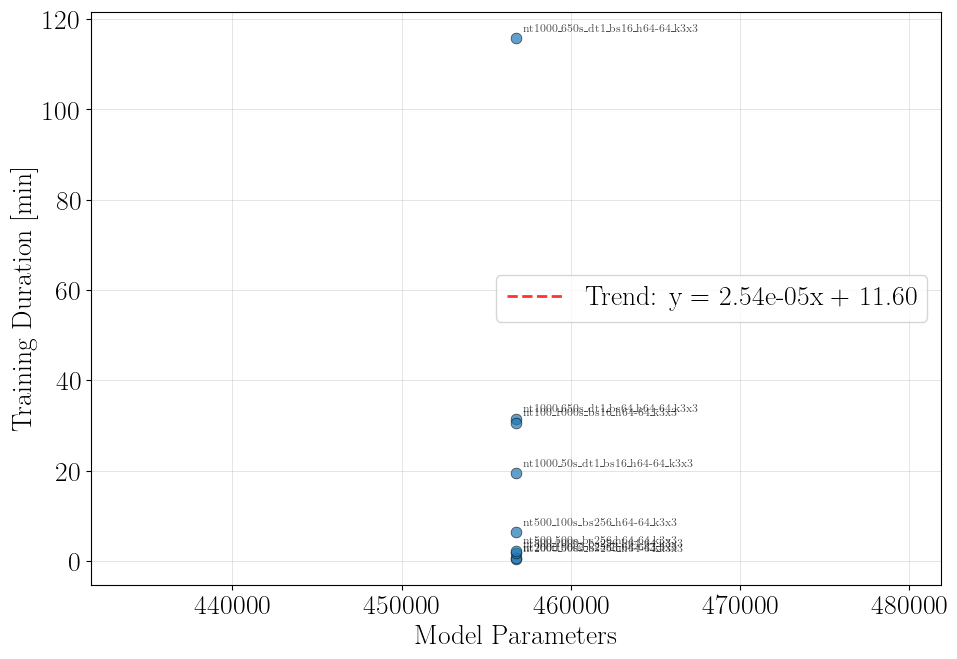


📊 ESTADÍSTICAS DE ENTRENAMIENTO
Model                     Parameters   Time [min]   Epochs   Val Loss  
--------------------------------------------------------------------------------
nt1000_50s_dt1_bs16_h64-64_k3x3 456769       19.45        27       0.0002    
nt1000_650s_dt1_bs16_h64-64_k3x3 456769       115.72       53       0.9568    
nt1000_650s_dt1_bs64_h64-64_k3x3 456769       31.51        54       1.0454    
nt100_1000s_bs16_h64-64_k3x3 456769       30.58        78       0.7009    
nt2000_500s_bs256_h64-64_k3x3 456769       0.53         5        0.9803    
nt200_100s_bs256_h64-64_k3x3 456769       0.70         63       0.8183    
nt500_1000s_bs256_h64-64_k3x3 456769       1.67         62       0.6270    
nt500_100s_bs256_h64-64_k3x3 456769       6.31         237      0.0046    
nt500_500s_bs256_h64-64_k3x3 456769       2.29         84       0.3951    

📈 Correlación parámetros-tiempo: nan
⏱️  Tiempo promedio: 23.20 min
🔢 Parámetros promedio: 456769
📊 Rango de parámetros: 4567

c:\Users\ismag\anaconda3\envs\ismael\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\ismag\anaconda3\envs\ismael\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\ismag\AppData\Local\Temp\ipykernel_12324\2751063246.py:233: RankWarning: Polyfit may be poorly conditioned
  z1 = np.polyfit(model_params, overall_mae, 1)
C:\Users\ismag\AppData\Local\Temp\ipykernel_12324\2751063246.py:251: RankWarning: Polyfit may be poorly conditioned
  z2 = np.polyfit(model_params, final_mae, 1)


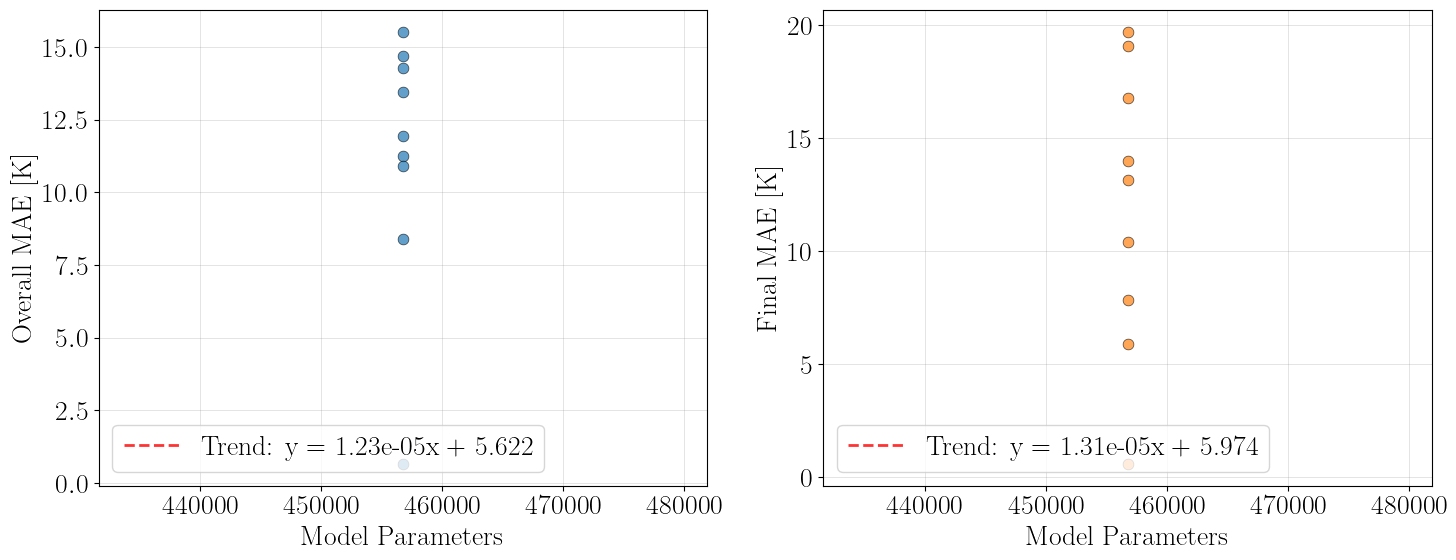


📊 ANÁLISIS ERROR vs PARÁMETROS
Model                     Parameters   Overall MAE  Final MAE    Time [min]  
------------------------------------------------------------------------------------------
nt1000_50s_dt1_bs16_h64-64_k3x3 456769       0.659        0.591        19.45       
nt1000_650s_dt1_bs16_h64-64_k3x3 456769       15.536       19.721       115.72      
nt1000_650s_dt1_bs64_h64-64_k3x3 456769       8.408        5.877        31.51       
nt100_1000s_bs16_h64-64_k3x3 456769       13.474       10.413       30.58       
nt2000_500s_bs256_h64-64_k3x3 456769       11.946       7.860        0.53        
nt200_100s_bs256_h64-64_k3x3 456769       11.256       13.168       0.70        
nt500_1000s_bs256_h64-64_k3x3 456769       10.928       14.012       1.67        
nt500_100s_bs256_h64-64_k3x3 456769       14.713       16.791       6.31        
nt500_500s_bs256_h64-64_k3x3 456769       14.274       19.094       2.29        

📈 CORRELACIONES:
   Parámetros vs Overall MAE: nan
   Pa

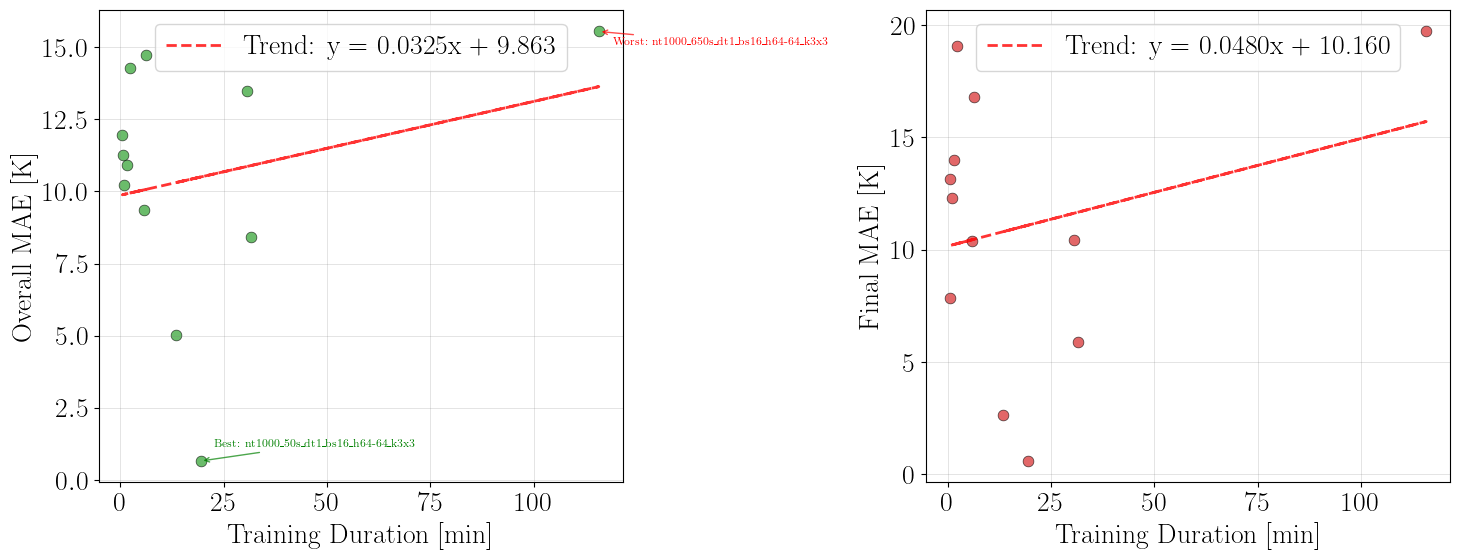


📊 ANÁLISIS ERROR vs TIEMPO DE ENTRENAMIENTO
Model                     Time [min]   Overall MAE  Final MAE    Parameters  
-----------------------------------------------------------------------------------------------
nt2000_500s_bs256_h64-64_k3x3 0.53         11.946       7.860        456769      
nt200_100s_bs256_h64-64_k3x3 0.70         11.256       13.168       456769      
nt200_50s_bs256_h64-64_k3x3 0.96         10.229       12.309       0           
nt500_1000s_bs256_h64-64_k3x3 1.67         10.928       14.012       456769      
nt500_500s_bs256_h64-64_k3x3 2.29         14.274       19.094       456769      
nt500_20s_bs256_h64-64_k3x3 5.81         9.366        10.408       0           
nt500_100s_bs256_h64-64_k3x3 6.31         14.713       16.791       456769      
nt1000_50s_dt1_bs256_h64-64_k3x3 13.40        5.016        2.652        0           
nt1000_50s_dt1_bs16_h64-64_k3x3 19.45        0.659        0.591        456769      
nt100_1000s_bs16_h64-64_k3x3 30.58        13.

In [78]:
# Ejecutar análisis de eficiencia de entrenamiento
training_efficiency_info, error_vs_params_info, error_vs_time_info = analyze_training_efficiency(
    comparison_results=all_comparison_results,
    configs_dict=all_configs_efficiency,
    save_figures=True,
    figures_path=FIGURES_PATH
)

print(f"\n📊 Análisis de eficiencia completado!")
print(f"   ⏱️  Información de entrenamiento: {len(training_efficiency_info)} modelos")
print(f"   📈 Información error vs parámetros: {len(error_vs_params_info)} modelos")
print(f"   🕒 Información error vs tiempo: {len(error_vs_time_info)} modelos")